# Прогнозирование оттока клиентов провайдера

**Целью проекта** является выявление оттока клиентов из компании-оператора телефонной связи и интернета. Своевременное прогнозирование оттока позволит компании вовремя проводить удерживающие маркетинговые мероприятия и увеличивать лояльность среди клиентов, а так же сократить расходы на удержание таких клиентов.

Прогнозирование оттока клиентов будет решаться задачей классификацией с применением машинного обучения.

**Этапы проекта:**
1. **Обзор данных**:

    Загрузим данные в тетрадку и проведем их предварительный обзор для понимания дальнейших действий.
2. **Предобработка данных**:
    * объединим таблицы;
    * обработаем пропущенные значения;
    * обработаем аномалий и дубликаты;
    * приведем данные к нужным форматам.
3. **Исследовательский анализ данных**:
    * проверим данные на полноту и распределение;
    * проверим данные на аномалии;
    * проверим баланс классов целевой переменной;
    * проведем корреляционный анализ;
    * построим соответствующие графики.
4. **Подготовка данных для обучения:**
    * разобьем датасет на train и test выборки;
    * проведем кодирование категориальных фичей;
    * проведем масштабирование.
4. **Обучение моделей**:
    * обучим модели;
    * посмотрим на результат их работы;
    * для улучшения метрик проведем тюнинг гиперпараметров и накрутим кросс-валидацию;
    * для финальной оценки лучшей модели проверим модель на test выборке.
    
    Для оценки моделей будем использовать метрики AUR-ROC и Accuracy.
5. **Общий вывод**:

    Напишем общий вывод и отчет о проделанной работе.

## Обзор данных

Загрузим данные в тетрадку и проведем их предварительный обзор для понимания дальнейших действий.

In [1]:
# Импорт стандартных библиотек
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import GridSearchCV, train_test_split

# Импорт сторонних библиотек
import phik
from catboost.utils import get_roc_curve
from catboost import CatBoostClassifier, Pool

In [2]:
# Обработка исключений для подгрузки данных с севера или локального компьютера
try:
    contract = pd.read_csv('D:\\Users\\BlackEdition\\Desktop\\Data Science\\'
                           'Обучение в Яндекс\\17. Выпускной проект\\final_provider\\contract.csv')
    internet = pd.read_csv('D:\\Users\\BlackEdition\\Desktop\\Data Science\\'
                           'Обучение в Яндекс\\17. Выпускной проект\\final_provider\\internet.csv')
    personal = pd.read_csv('D:\\Users\\BlackEdition\\Desktop\\Data Science\\'
                           'Обучение в Яндекс\\17. Выпускной проект\\final_provider\\personal.csv')
    phone = pd.read_csv('D:\\Users\\BlackEdition\\Desktop\\Data Science\\'
                        'Обучение в Яндекс\\17. Выпускной проект\\final_provider\\phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')

Выедем датасеты и информацию о них на экран.

In [3]:
display(contract.info())
display(contract)
display(contract.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


None

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65
...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6


,count,mean,std,min,25%,50%,75%,max
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


Датасет состоит из 8 колонок и 7043 строк, описывающих контрактную часть с клиентами:
* customerID - ID покупателя;
* BeginDate - дата начала действия договора;
* EndDate - дата окончания договора;
* Type - тип договора по сроку действия;
* PaperlessBilling - безбумажное заполнение договора;
* PaymentMethod - метод оплаты договора;
* MonthlyCharges - ежемесячные платежи;
* TotalCharges - итоговая сумма платежей.

Средняя сумма ежемесячных платежей среди клиентв составляет 64.76 ye., медиана 70.35 ye.

In [4]:
display(internet.info())
display(internet)
display(internet.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


None

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No
...,...,...,...,...,...,...,...,...
5512,6840-RESVB,DSL,Yes,No,Yes,Yes,Yes,Yes
5513,2234-XADUH,Fiber optic,No,Yes,Yes,No,Yes,Yes
5514,4801-JZAZL,DSL,Yes,No,No,No,No,No
5515,8361-LTMKD,Fiber optic,No,No,No,No,No,No


,count,unique,top,freq
customerID,5517,5517,7590-VHVEG,1
InternetService,5517,2,Fiber optic,3096
OnlineSecurity,5517,2,No,3498
OnlineBackup,5517,2,No,3088
DeviceProtection,5517,2,No,3095
TechSupport,5517,2,No,3473
StreamingTV,5517,2,No,2810
StreamingMovies,5517,2,No,2785


Датасет состоит из 8 колонок и 5517 строк, описывающих интернет услуги:

* InternetService - тип интернет соединения;
* OnlineSecurity - онлайн безопасность;
* OnlineBackup - резервная копия данных;
* DeviceProtection - антивирус;
* TechSupport - поддержка;
* StreamingTV - стриминговое телевидение;
* StreamingMovies - каталог фильмов.

Соотношение покупаемых и непокупаемых услуг в пользу непокупаемых. Каталог фильмов берут чаще, чем остальные услуги. Преобладающий тип интернет соединения - оптоволокно.

In [5]:
display(personal.info())
display(personal)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


None

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No
...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes
7039,2234-XADUH,Female,0,Yes,Yes
7040,4801-JZAZL,Female,0,Yes,Yes
7041,8361-LTMKD,Male,1,Yes,No


Датасет состоит из 5 колонок и 7043 строк, описывающих клиентов:

* InternetService - тип интернет соединения;
* gender - пол;
* SeniorCitizen - пожилой возраст;
* Partner - партнер компании;
* Dependents - инживенец.

In [6]:
display(phone.info())
display(phone)
display(phone.describe().T)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


None

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes
...,...,...
6356,2569-WGERO,No
6357,6840-RESVB,Yes
6358,2234-XADUH,Yes
6359,8361-LTMKD,Yes


,count,unique,top,freq
customerID,6361,6361,5575-GNVDE,1
MultipleLines,6361,2,No,3390


Датасет состоит из 2 колонок и 6361 строк, описывающих клиентов с подключенной телефонией:

* InternetService - тип интернет соединения;
* MultipleLines - множественные линии.
 
 Среди пользователей преобладает телефония с 1 линией.

Выведем на экран все уникальные уникальные значения и их встречаемость в датасетах с целью посмотреть на скрытые аномалии.

In [7]:
# Вывод уникальных значений каждого признака, отсортированных по убыванию
datasets = {'contract': contract,
            'internet': internet,
            'personal': personal,
            'phone': phone}

for key, value in datasets.items():
    display(key)
    for column in value:
        display(column)
        display(value[column].value_counts().sort_values())
        display()
    display('-----------------------------------------------------------------------------------------')

'contract'

'customerID'

7590-VHVEG    1
9237-HQITU    1
9305-CDSKC    1
1452-KIOVK    1
6713-OKOMC    1
             ..
8361-LTMKD    1
1122-JWTJW    1
4807-IZYOZ    1
6894-LFHLY    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

'BeginDate'

2013-11-01      2
2013-12-01      3
2013-10-01      3
2014-01-01      7
2020-02-01     11
             ... 
2020-01-01    233
2019-09-01    237
2019-11-01    237
2019-10-01    237
2014-02-01    366
Name: BeginDate, Length: 77, dtype: int64

'EndDate'

2019-10-01 00:00:00     458
2020-01-01 00:00:00     460
2019-12-01 00:00:00     466
2019-11-01 00:00:00     485
No                     5174
Name: EndDate, dtype: int64

'Type'

One year          1473
Two year          1695
Month-to-month    3875
Name: Type, dtype: int64

'PaperlessBilling'

No     2872
Yes    4171
Name: PaperlessBilling, dtype: int64

'PaymentMethod'

Credit card (automatic)      1522
Bank transfer (automatic)    1544
Mailed check                 1612
Electronic check             2365
Name: PaymentMethod, dtype: int64

'MonthlyCharges'

78.70     1
62.55     1
40.90     1
26.50     1
56.00     1
         ..
20.00    43
19.90    44
19.95    44
19.85    45
20.05    61
Name: MonthlyCharges, Length: 1585, dtype: int64

'TotalCharges'

7674.55     1
155.8       1
5293.95     1
4759.85     1
6148.45     1
           ..
19.9        8
20.05       8
19.75       9
20.2       11
           11
Name: TotalCharges, Length: 6531, dtype: int64

'-----------------------------------------------------------------------------------------'

'internet'

'customerID'

7590-VHVEG    1
9305-CDSKC    1
1452-KIOVK    1
6713-OKOMC    1
7892-POOKP    1
             ..
7203-OYKCT    1
1699-HPSBG    1
1122-JWTJW    1
8456-QDAVC    1
3186-AJIEK    1
Name: customerID, Length: 5517, dtype: int64

'InternetService'

DSL            2421
Fiber optic    3096
Name: InternetService, dtype: int64

'OnlineSecurity'

Yes    2019
No     3498
Name: OnlineSecurity, dtype: int64

'OnlineBackup'

Yes    2429
No     3088
Name: OnlineBackup, dtype: int64

'DeviceProtection'

Yes    2422
No     3095
Name: DeviceProtection, dtype: int64

'TechSupport'

Yes    2044
No     3473
Name: TechSupport, dtype: int64

'StreamingTV'

Yes    2707
No     2810
Name: StreamingTV, dtype: int64

'StreamingMovies'

Yes    2732
No     2785
Name: StreamingMovies, dtype: int64

'-----------------------------------------------------------------------------------------'

'personal'

'customerID'

7590-VHVEG    1
9237-HQITU    1
9305-CDSKC    1
1452-KIOVK    1
6713-OKOMC    1
             ..
8361-LTMKD    1
1122-JWTJW    1
4807-IZYOZ    1
6894-LFHLY    1
3186-AJIEK    1
Name: customerID, Length: 7043, dtype: int64

'gender'

Female    3488
Male      3555
Name: gender, dtype: int64

'SeniorCitizen'

1    1142
0    5901
Name: SeniorCitizen, dtype: int64

'Partner'

Yes    3402
No     3641
Name: Partner, dtype: int64

'Dependents'

Yes    2110
No     4933
Name: Dependents, dtype: int64

'-----------------------------------------------------------------------------------------'

'phone'

'customerID'

5575-GNVDE    1
7892-POOKP    1
6388-TABGU    1
9763-GRSKD    1
7469-LKBCI    1
             ..
4807-IZYOZ    1
5306-BVTKJ    1
1471-GIQKQ    1
0376-OIWME    1
3186-AJIEK    1
Name: customerID, Length: 6361, dtype: int64

'MultipleLines'

Yes    2971
No     3390
Name: MultipleLines, dtype: int64

'-----------------------------------------------------------------------------------------'

### Вывод

Из проведенного обзора данных можно сделать следующие выводы:
* колонки BeginDate и EndDate необходимо привести к формату DateTime в целях исследовательского анализа данных. После анализа колонки можно будет удалить, т.к. они будут лишними для моделей;
* колонка EndDate является целевым признаком для классификации клиентов на активных и прогнозируемых к оттоку. Колонка имеет смешанный формат данных. Необходимо привести ее к бинарному виду для дальнейшей классификации клиентов на активных (0) и прогнозируемых к оттоку (1). Но, в связи с тем, что сама по себе информация о окончании действия договора, возможно, несет в себе практическую пользу для моделей (можно сгенерировать отдельную фичу с продолжительность действия договора и посмотреть как она влияет на метрики моделей), перед приведением целевого признака в бинарный вид мы сгенерируем дополнительную фичу с помощью колонок BeginDate и EndDate;
* колонку TotalCharges необходимо привести к float формату, дополнительно в колонке есть скрытые пропуски из-за чего, возможно, формат колонки типа object. Заменим их на 0 или удалим.
* необходимо провести кодирование категориальных колонок в каждом из датасетов;
* необходимо произвести масштабирование категориальных колонок;
* полезность фичи MonthlyCharges для моделей под вопросом, т.к. платежи гомогенны, без динамики. Можно попробовать посмотреть метрики с этой фичей и без;
* данные необходимо будет объединить в один датафрейм.

## Предобработка данных

Объединим таблицы, чтобы проще было работать с данными.

In [8]:
# Объединение датасетов в один фрейм
data = contract.merge(internet, how='left', on='customerID')
data = data.merge(personal, how='left', on='customerID')
data = data.merge(phone, how='left', on='customerID')
data

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,NaN
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes


### Проверка на пропуски

Проверим датасет на пропуски.

In [9]:
data.isna().sum()

customerID             0
BeginDate              0
EndDate                0
Type                   0
PaperlessBilling       0
PaymentMethod          0
MonthlyCharges         0
TotalCharges           0
InternetService     1526
OnlineSecurity      1526
OnlineBackup        1526
DeviceProtection    1526
TechSupport         1526
StreamingTV         1526
StreamingMovies     1526
gender                 0
SeniorCitizen          0
Partner                0
Dependents             0
MultipleLines        682
dtype: int64

Видно, что в данных присутствуют пропуски из-за несоответствия размерности таблиц Contract, Internet и Phone. Посмотрим поконкретнее, что это за пропуски. Допустим, имеются ли такие клиенты, которые не пользуются ни интернетом ни телефонией?

In [10]:
# Проверка датасета на NAN
data.loc[(data['InternetService'].isnull()) & (data['MultipleLines'].isnull())]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines


Клиентов, которые не пользуются ни интернетом ни телефонией нет, соответсвенно все клиенты у нас задействованы в обслуживании и всех их можно брать в расчет модели (не удалять пропуски).

В связи с тем, что в столбцах имеются пропуски - заменем их соответствующими значениями. Т.к. пропуски во всех категориальных столбцах с одинаковым бинарным разбиением (Yes or No) - заменим все NAN значения на "No", как не употребляемые клиентами услуги.

In [11]:
# Замена NAN на 'No'
columns = []

# Цикл, ищущий NAN в кололнках
for column in data.columns:
    if data[column].isnull().sum() > 0:
        columns.append(column)

display(f'Колонки с NAN: {columns}')

# Цикл, заменяющий найденные в колонках NAN на 'No'
for column in columns:
    data[column] = data[column].fillna('No')

display(data.isnull().sum())
display(data)

"Колонки с NAN: ['InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']"

customerID          0
BeginDate           0
EndDate             0
Type                0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
MultipleLines       0
dtype: int64

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.5,DSL,Yes,No,Yes,Yes,Yes,Yes,Male,0,Yes,Yes,Yes
7039,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.9,Fiber optic,No,Yes,Yes,No,Yes,Yes,Female,0,Yes,Yes,Yes
7040,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,DSL,Yes,No,No,No,No,No,Female,0,Yes,Yes,No
7041,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.6,Fiber optic,No,No,No,No,No,No,Male,1,Yes,No,Yes


### Проверка на дубликаты

Проверим датасет на явные дубликаты.

In [12]:
data.duplicated().sum()

0

Явные дубликаты в данных отсутствуют.

### Удаление неявных пропусков и приведение типов

При обозоре данных мы выявили, что в колонке TotalCharges имеются аномалии в виде пустой строки. Т.к. данные в других столбцах могут быть полезными - не будем удалять 11 аномалий, а заменим их на нули.

In [13]:
data['TotalCharges'].value_counts()

          11
20.2      11
19.75      9
20.05      8
19.9       8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6531, dtype: int64

data['TotalCharges'] = data['TotalCharges'].replace([' '], 0)
data['TotalCharges'] = data['TotalCharges'].replace([' '], data['TotalCharges'].median())
data['TotalCharges'].value_counts()

In [14]:
data = data[data['TotalCharges'] != ' ']

In [15]:
data['TotalCharges'].value_counts()

20.2      11
19.75      9
20.05      8
19.9       8
19.65      8
          ..
6849.4     1
692.35     1
130.15     1
3211.9     1
6844.5     1
Name: TotalCharges, Length: 6530, dtype: int64

In [16]:
data.loc[data['TotalCharges'] == 0]

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines


Теперь приведем колонку TotalCharges к типу float.

In [17]:
data['TotalCharges'] = data['TotalCharges'].astype(float)

C:\Users\BLACKE~1\AppData\Local\Temp/ipykernel_5128/1864821250.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['TotalCharges'] = data['TotalCharges'].astype(float)


Все колонки приведены к необходимым форматам.

### Майнинг таргета и дополнительных фич

Выделем таргет в отдельный столбец, чтобы произвести манипуляции со столбцами BeginDate и EndDate, вычислив CLF (customerlifecycle). Также приведем таргет в бинарный вид.

In [19]:
data['target'] = data['EndDate']
data.head()

C:\Users\BLACKE~1\AppData\Local\Temp/ipykernel_5128/1294797757.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['EndDate']


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,2019-12-01 00:00:00
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,No,No
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,2019-11-01 00:00:00


In [20]:
'''Цикл для преобразования уникальных значений
в признаке target в бинарную классификацию (1 или 0).
Тем самым мы майним таргет.
'''


for i in data['target'].unique():
    if i != 'No':
        data['target'] = data['target'].replace(i, 1)
    data['target'] = data['target'].replace(i, 0)

data.head()

C:\Users\BLACKE~1\AppData\Local\Temp/ipykernel_5128/1570099811.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(i, 0)
C:\Users\BLACKE~1\AppData\Local\Temp/ipykernel_5128/1570099811.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['target'] = data['target'].replace(i, 1)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,No,Female,0,Yes,No,No,0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,Yes,No,No,No,Male,0,No,No,No,0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,No,Male,0,No,No,No,1
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,Yes,No,No,Male,0,No,No,No,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,No,Female,0,No,No,No,1


In [21]:
'''Значения "No" в EndDate заменим на дату "2020-02-01"
в целью дальнейшего расчета customer life cycle.
Также проведем необходимые преобразования типов.
'''


data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')
data['BeginDate'] = data['BeginDate'].astype('datetime64')
data['EndDate'] = data['EndDate'].astype('datetime64')

data[['BeginDate', 'EndDate']].head()

C:\Users\BLACKE~1\AppData\Local\Temp/ipykernel_5128/3606255872.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['EndDate'] = data['EndDate'].replace('No', '2020-02-01')
C:\Users\BLACKE~1\AppData\Local\Temp/ipykernel_5128/3606255872.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['BeginDate'] = data['BeginDate'].astype('datetime64')
C:\Users\BLACKE~1\AppData\Local\Temp/ipykernel_5128/3606255872.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.


,BeginDate,EndDate
0,2020-01-01,2020-02-01
1,2017-04-01,2020-02-01
2,2019-10-01,2019-12-01
3,2016-05-01,2020-02-01
4,2019-09-01,2019-11-01


In [22]:
data['customer_life_cycle'] = ((data['EndDate'] - data['BeginDate']).astype('timedelta64[D]')
                                                                    .astype('int'))
data.head()

C:\Users\BLACKE~1\AppData\Local\Temp/ipykernel_5128/3268126585.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['customer_life_cycle'] = ((data['EndDate'] - data['BeginDate']).astype('timedelta64[D]')


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,...,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,target,customer_life_cycle
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,...,No,No,No,Female,0,Yes,No,No,0,31
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,DSL,Yes,...,No,No,No,Male,0,No,No,No,0,1036
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,...,No,No,No,Male,0,No,No,No,1,61
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,...,Yes,No,No,Male,0,No,No,No,0,1371
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,...,No,No,No,Female,0,No,No,No,1,61


### Вывод

В рамках первичной предобработки данных мы выполнили проверку датасета на пропуски, дубликаты, аномалии. Дополнительно нами был замайнена новая фича и определена целевая переменная. Первичная предобработка данных позволит нам провести ислледовательский анализ данных без артефактов в построенных графиках.

Вторичную обработку данных, а вернее их подготовку к машинному обучению будем делать в пункте 1.4 проекта.

## Исследовательский анализ данных

Проведем исследовательский анализ данных:
* проверим данные на полноту и распределение;
* проверим данные на аномалии и дубликаты (возможо они проявятся на графиках);
* проверим баланс классов;
* построим соответствующие графики.

### Проверка на полноту, распределение и аномалии

Посмотрим на распределение данных и отсутствие в их аномалий.

Text(0, 0.5, 'Количество заключенных договоров')

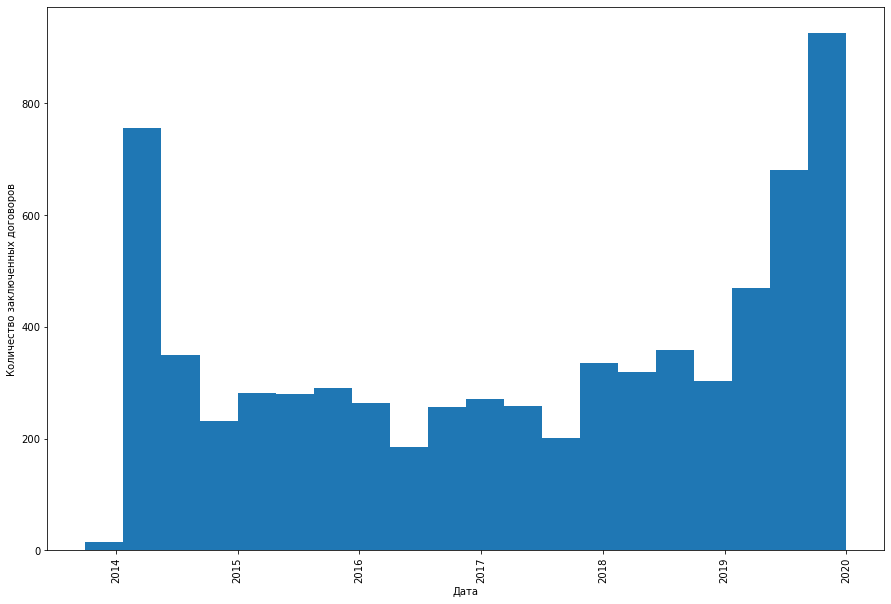

In [23]:
plt.figure(figsize=(15, 10))

plt.hist(data['BeginDate'], bins=20)
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Количество заключенных договоров')

Дата начала договоров равномерно распределена по годам за исключением 2014 года и конца 2019 года. Возможно в 2014 году компания начала деятельность и заключила своим первые договоры. Причина заключения большого количества договоров в 2019 году неизвестна и требует отдельного анализа.

Text(0, 0.5, 'Оток клиентов')

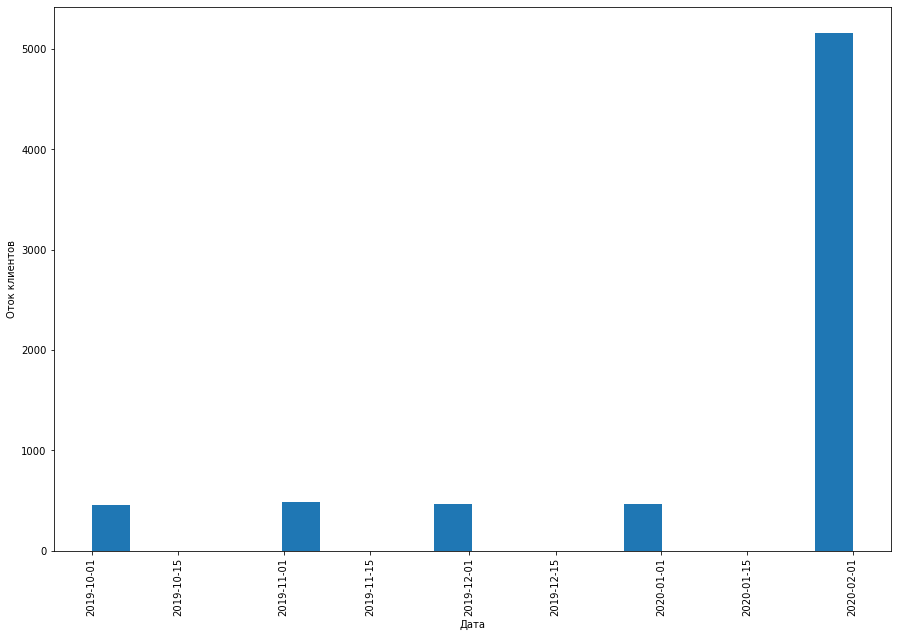

In [24]:
plt.figure(figsize=(15, 10))

plt.hist(data['EndDate'], bins=20)
plt.xticks(rotation=90)
plt.xlabel('Дата')
plt.ylabel('Оток клиентов')

Отток клиентов компании равномерный. Фиксировать отток компания, видимо, начала в 2019 и делает это ежемесячно в 1 числах месяца. Большой отток 2020-02-01 не аномалия, а следствие нашей предобработки данных. Эта информация не несет пользы для нас.

Посмотрим на распределение ежемесячных платежей среди ушедших пользователей по сравнению с клиентами, которые до сих пор пользуются услугами компании.

Text(0, 0.5, 'Количество заключенных договоров')

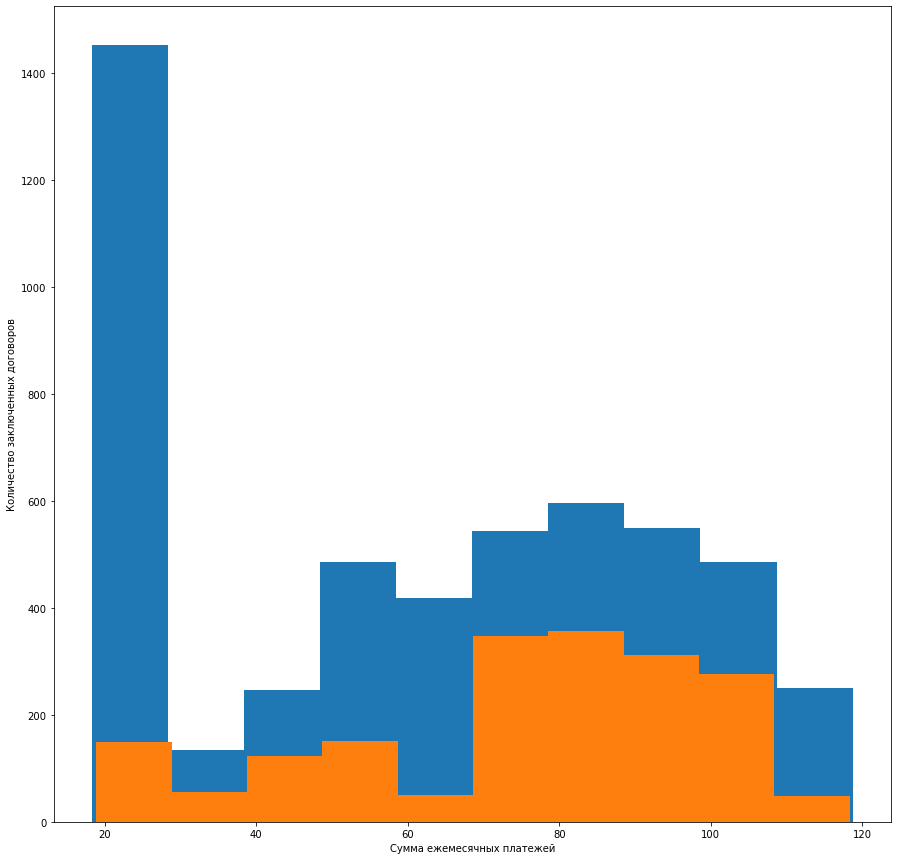

In [25]:
fig, ax = plt.subplots(figsize=(15, 15))

plt.hist(data.loc[data['target'] == 0]['MonthlyCharges'])
plt.hist(data.loc[data['target'] == 1]['MonthlyCharges'])
plt.xlabel('Сумма ежемесячных платежей')
plt.ylabel('Количество заключенных договоров')

Распределения по ежемесячным платежам одинаковы. Также видна мультимодальность распределения (несколько пиков).

Посмотрим на распределение итоговых сумм платежей среди ушедших пользователей по сравнению с клиентами, которые до сих пор пользуются услугами компании.

Text(0, 0.5, 'Количество заключенных договоров')

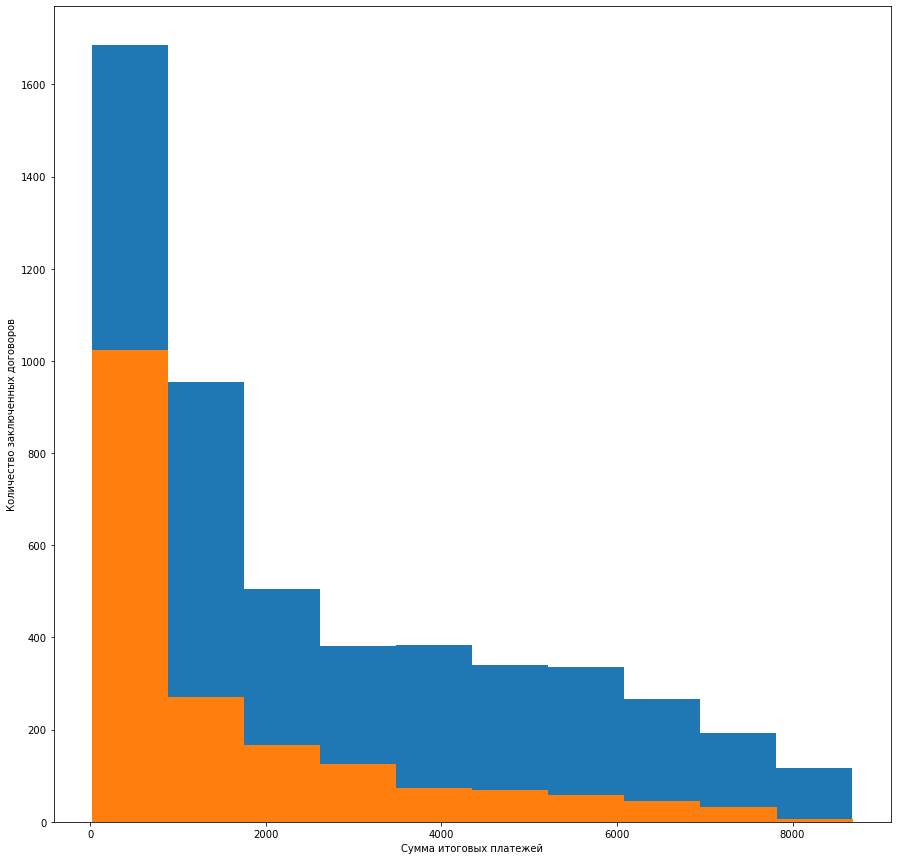

In [26]:
fig, ax = plt.subplots(figsize=(15, 15))

plt.hist(data.loc[data['target'] == 0]['TotalCharges'])
plt.hist(data.loc[data['target'] == 1]['TotalCharges'])
plt.xlabel('Сумма итоговых платежей')
plt.ylabel('Количество заключенных договоров')

Распределение итоговых платежей тоже одиковое.

Теперь посмотрим на распределение жизненного цикла клиента.

Text(0, 0.5, 'Количество заключенных договоров')

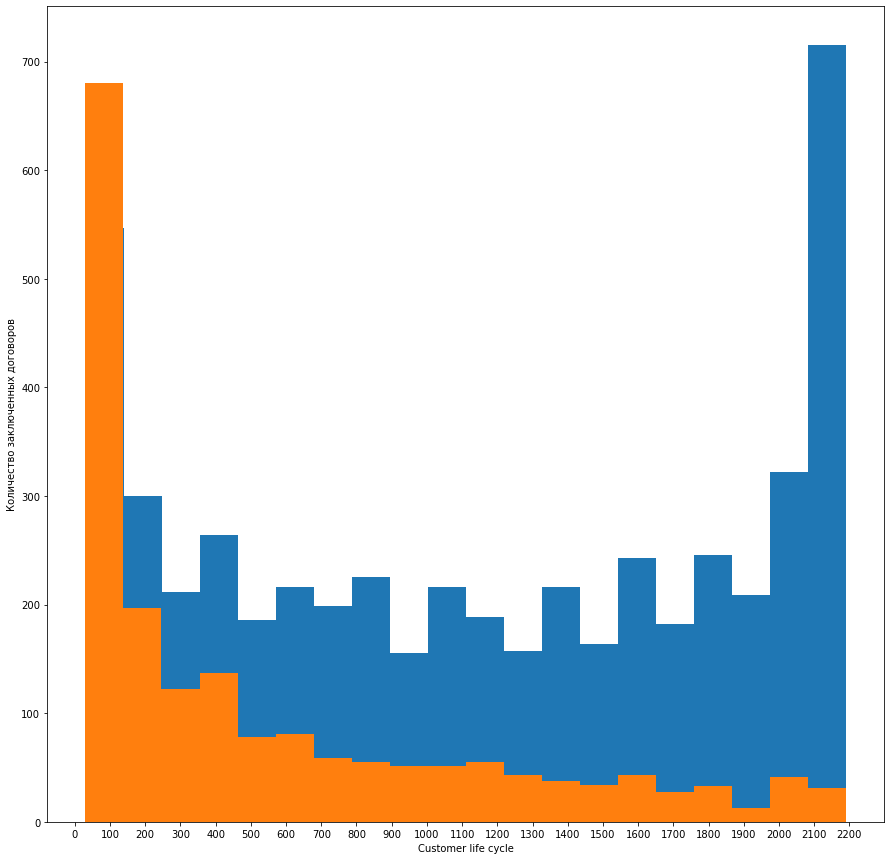

In [27]:
fig, ax = plt.subplots(figsize=(15, 15))
ax.xaxis.set_major_locator(ticker.MultipleLocator(100))

plt.hist(data.loc[data['target'] == 0]['customer_life_cycle'], bins=20)
plt.hist(data.loc[data['target'] == 1]['customer_life_cycle'], bins=20)
plt.xlabel('Customer life cycle')
plt.ylabel('Количество заключенных договоров')

Ушедшие клиенты чаще всего пользовались услугами компании короткое время (около 100 дней). В целом утечка клиентов есть, но она не привязана к каким-то событиям.

### Баланс классов целевой переменной

Проверим балансировку классов у целевого признака.

Text(0, 0.5, 'Количество заключенных договоров')

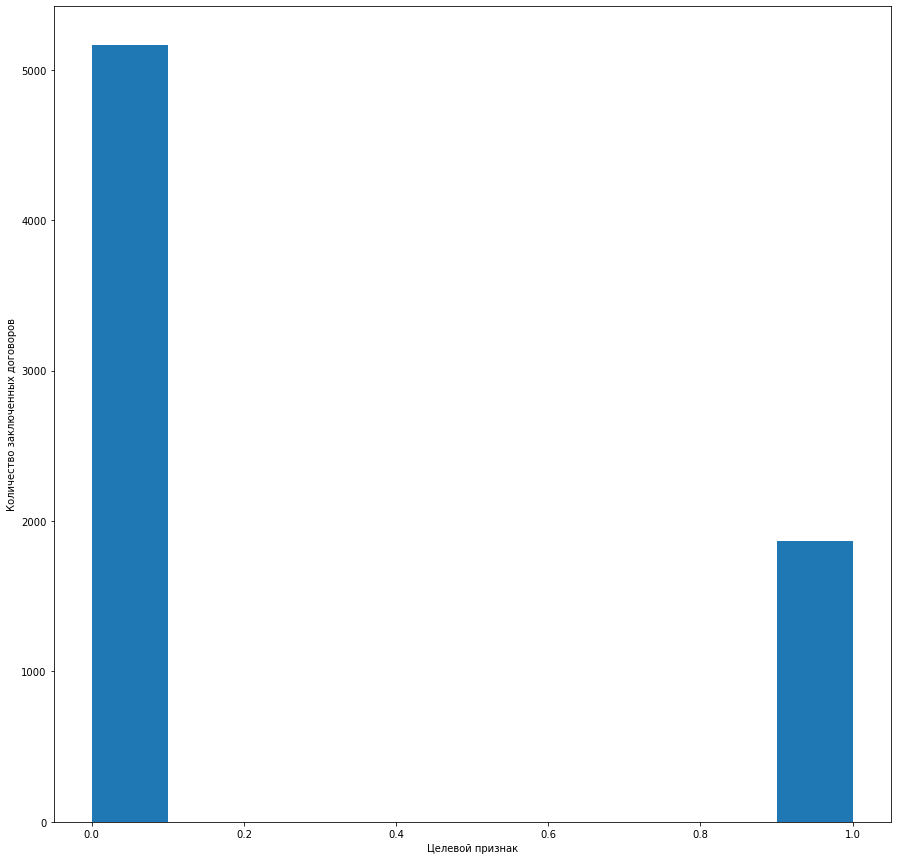

In [28]:
fig, ax = plt.subplots(figsize=(15, 15))

plt.hist(data['target'])
plt.xlabel('Целевой признак')
plt.ylabel('Количество заключенных договоров')

Из гистограммы видно, что ушедших пользователей в несколько раз меньше, чем активных. В связи с этим при обучении моделей машинного обучения будем использовать балансировку классов.

### Анализ выбросов

Посмотрим на выбросы в ежемесячных платежах и общей сумме платежей.

(0.0, 200.0)

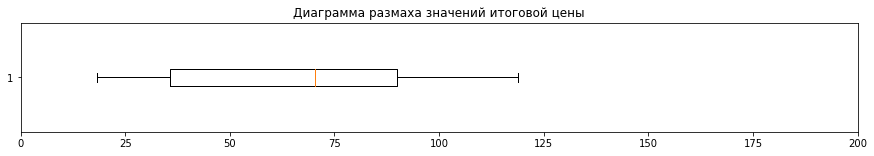

In [29]:
fig, ax = plt.subplots(figsize=(15, 2))
plt.boxplot(data['MonthlyCharges'], vert=False)
ax.set_title('Диаграмма размаха значений итоговой цены')
ax.set_xlim(0, 200)

(0.0, 15000.0)

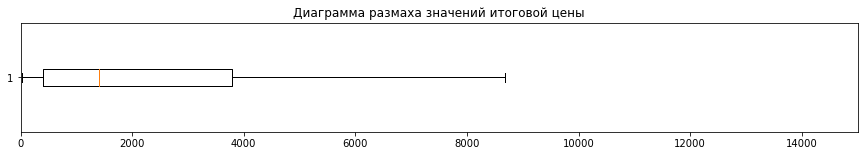

In [30]:
fig, ax = plt.subplots(figsize=(15, 2))
plt.boxplot(data['TotalCharges'], vert=False)
ax.set_title('Диаграмма размаха значений итоговой цены')
ax.set_xlim(0, 15000)

Выбросов не выявлено. Все значения находятся в диапазоне полуторного межквартильного расстояния.

### Корреляционный анализ

Воспользуемся библиотекой phik для оценки корреляции различных гиперпараметров между собой.

In [1]:
corr_matrix = data.phik_matrix()
corr_matrix

NameError: name 'data' is not defined

Выведем коррелционные данные на тепловую карту для удобства анализа.

<AxesSubplot:>

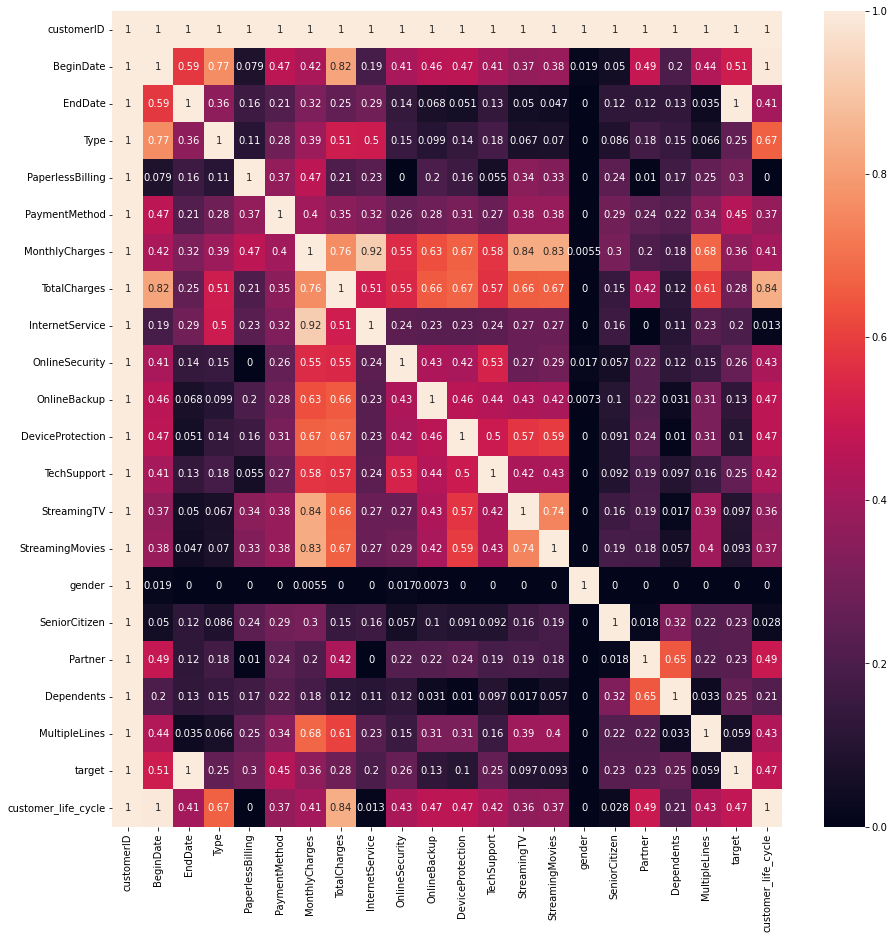

In [32]:
plt.figure(figsize=(15, 15))
sns.heatmap(corr_matrix, annot=True)

Исходя из тепловой карты видно, что у нас высокая корреляция между показателем EndDate и target, что логично, учитывая, что эти показатели идентичны. Аналогичная ситуация с BeginDate и customer_life_cycle.

Также высокая корреляция наблюдается между показателями customer_life_cycle и TotalCharges, MontlyCharges и InternetService.

Признак gender позал отсутствие корреляции почти со всеми показателями. Скорее всего данный признак не даст какого-либо прироста метрики моделей машинного обучения. Мы можем его удалить.

Таже удалим мультиколлинеарные признаки BeginDate и EndDate.

### Вывод

Мы провели краткий исследовательский анализ данных. Нами были оценены распределение, и полнота данных, определена необходимость балансироваки классов в рамках машинного обучения, произведен анализ выбросов количественных признаков с помощью ящиков с усами, проведен корреляционный анализ.

В рамках полноты и распределение данных - порядок, - в данных нет никаких пропусков, которые мы могли не заметить в рамках первичной предобработки данных.

Модели машинного обучения требуют балансировки классов, т.к. разница между утекшими и активными пользователями существенна.

Исходя из ящиков с усами выбросов количественных данных у нас нет, их нормализация не трубуется.

Корреляционный анализ показал зависимость таких признаков, как:
* EndDate и target;
* BeginDate и customer_life_cycle;
* customer_life_cycle и TotalCharges;
* MontlyCharges и InternetService.

Признак gender не коррелирует ни с одним из других фичей, в связи с чем мы можем удалить его из датасета на этапе подготовки данных для обучения.

## Подготовка данных для обучения

### Удаление лишних признаков

Удалим признаки, которые помешают модели обучиться.

In [33]:
data = data.drop(columns=[
    'customerID',
    'BeginDate',
    'EndDate',
    'gender',
    'TotalCharges'], axis=1)
data.columns

Index(['Type', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges',
       'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'StreamingTV', 'StreamingMovies', 'SeniorCitizen',
       'Partner', 'Dependents', 'MultipleLines', 'target',
       'customer_life_cycle'],
      dtype='object')

### Разделение датасета на обучающую и тестовую выборки

Разделим датасет на фичи и таргет.

In [34]:
features = data.drop('target', axis=1)
target = data['target']

display(features.shape)
display(target.shape)
display(features.head())

(7032, 16)

(7032,)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,SeniorCitizen,Partner,Dependents,MultipleLines,customer_life_cycle
0,Month-to-month,Yes,Electronic check,29.85,DSL,No,Yes,No,No,No,No,0,Yes,No,No,31
1,One year,No,Mailed check,56.95,DSL,Yes,No,Yes,No,No,No,0,No,No,No,1036
2,Month-to-month,Yes,Mailed check,53.85,DSL,Yes,Yes,No,No,No,No,0,No,No,No,61
3,One year,No,Bank transfer (automatic),42.30,DSL,Yes,No,Yes,Yes,No,No,0,No,No,No,1371
4,Month-to-month,Yes,Electronic check,70.70,Fiber optic,No,No,No,No,No,No,0,No,No,No,61


Разделим датасет на обучающую выборку, тестовую выборку и соответствующие таргеты.

In [35]:
X_train, X_test, y_train, y_test = train_test_split(features,
                                                    target,
                                                    test_size=.25,
                                                    random_state=160123)

display(X_train.shape)
display(X_test.shape)
display(y_train.shape)
display(y_test.shape)

(5274, 16)

(1758, 16)

(5274,)

(1758,)

### Кодирование категориальных переменных

Применим кодирование категориальных переменных с помощью OneHotEncoding.

In [36]:
# Сброс индексов для избежания появления NAN при join датасетов
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

ohe_columns = []

# Сбор категориальных признаков через цикл в список
for column in X_train.columns:
    if X_train[column].dtypes == object:
        ohe_columns.append(column)

# Обучение энкодера
encoder = OneHotEncoder(drop='first').fit(X_train[ohe_columns])
new_columns = encoder.get_feature_names(ohe_columns)

# Кодирование категориальных признаков, сбор train выборки
encoder_train = pd.DataFrame(encoder.transform(X_train[ohe_columns]).toarray(),
                             columns=new_columns)

X_train = X_train.join(encoder_train)
X_train = X_train.drop(columns=ohe_columns, axis=1)
display(X_train)

# Кодирование категориальных признаков, сбор test выборки
encoder_test = pd.DataFrame(encoder.transform(X_test[ohe_columns]).toarray(),
                            columns=new_columns)

X_test = X_test.join(encoder_test)
X_test = X_test.drop(columns=ohe_columns, axis=1)
display(X_test)

,MonthlyCharges,SeniorCitizen,customer_life_cycle,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Partner_Yes,Dependents_Yes,MultipleLines_Yes
0,20.40,0,123,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,24.80,0,427,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2,65.25,0,92,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
3,84.80,0,123,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0
4,64.20,0,62,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5269,25.05,0,2163,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0
5270,84.25,0,1310,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
5271,19.25,0,31,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5272,72.10,0,1067,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,0.0


,MonthlyCharges,SeniorCitizen,customer_life_cycle,Type_One year,Type_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,InternetService_Fiber optic,InternetService_No,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Partner_Yes,Dependents_Yes,MultipleLines_Yes
0,108.20,0,2191,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,1.0
1,44.45,0,245,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,79.85,0,2010,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
3,75.30,1,456,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,64.30,0,1584,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1753,89.40,0,610,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
1754,20.20,0,30,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1755,93.45,0,1614,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0
1756,101.10,0,457,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


### Вывод

В данном разделе нами были удалены признаки, не несущие пользы для машинного обучения (ID пользователей, даты).

## Обучение моделей

Обучим несколько моделей на данных и посмотрим на метрику AUC-ROC.

Будем собирать pipelin'ы для каждой модели. В нем будет scaler и модель. Сетку параметров укажем в словаре param_grid. Обучим модели черех GridSearchCV с помощью кросс-валидации с 5 фолдами.

Для обучения будем использовать следующие модели:
* LogisticRegression
* RandomForestClassifier
* CatBoostClassifier

### LogisticRegression

In [37]:
pipeline = Pipeline([("scaler", StandardScaler()),
                     ("lr", LogisticRegression(random_state=160123,
                                               class_weight='balanced'))])

param_grid = {
    'lr__solver': ['lbfgs', 'liblinear']
}

grid_pipeline = GridSearchCV(pipeline,
                             param_grid,
                             verbose=1,
                             cv=5,
                             scoring='roc_auc')

grid_pipeline.fit(X_train, y_train)
display(grid_pipeline.best_params_)
display(grid_pipeline.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


{'lr__solver': 'lbfgs'}

0.8386220633499027

### RandomForestClassifier

In [38]:
pipeline = Pipeline([("scaler", StandardScaler()),
                     ("rfc", RandomForestClassifier(random_state=160123,
                                                    class_weight='balanced'))])

param_grid = {
    'rfc__max_depth': [1, 10, 50],
    'rfc__n_estimators': [10, 50, 100]
}

grid_pipeline = GridSearchCV(pipeline,
                             param_grid,
                             verbose=1,
                             cv=5,
                             scoring='roc_auc')

grid_pipeline.fit(X_train, y_train)
display(grid_pipeline.best_params_)
display(grid_pipeline.best_score_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


{'rfc__max_depth': 10, 'rfc__n_estimators': 100}

0.8522695060692822

### CatboostClassifier

In [ ]:
pipeline = Pipeline([("cbc", CatBoostClassifier(random_state=160123,
                                                auto_class_weights='Balanced'))])

param_grid = {
    'cbc__learning_rate': [0.01, 0.1],
    'cbc__depth': [1, 10]
}

grid_pipeline = GridSearchCV(pipeline,
                             param_grid,
                             verbose=1,
                             cv=5,
                             scoring='roc_auc')

grid_pipeline.fit(X_train, y_train)
display(grid_pipeline.best_params_)
display(grid_pipeline.best_score_)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 0.6919046	total: 167ms	remaining: 2m 47s
1:	learn: 0.6900168	total: 170ms	remaining: 1m 24s
2:	learn: 0.6888105	total: 173ms	remaining: 57.4s
3:	learn: 0.6869808	total: 176ms	remaining: 43.7s
4:	learn: 0.6858064	total: 179ms	remaining: 35.6s
5:	learn: 0.6840221	total: 182ms	remaining: 30.2s
6:	learn: 0.6829135	total: 185ms	remaining: 26.2s
7:	learn: 0.6811857	total: 188ms	remaining: 23.4s
8:	learn: 0.6801332	total: 191ms	remaining: 21.1s
9:	learn: 0.6784596	total: 194ms	remaining: 19.2s
10:	learn: 0.6773234	total: 197ms	remaining: 17.7s
11:	learn: 0.6763462	total: 200ms	remaining: 16.5s
12:	learn: 0.6753195	total: 203ms	remaining: 15.4s
13:	learn: 0.6737065	total: 206ms	remaining: 14.5s
14:	learn: 0.6721440	total: 209ms	remaining: 13.8s
15:	learn: 0.6711775	total: 212ms	remaining: 13s
16:	learn: 0.6696560	total: 215ms	remaining: 12.4s
17:	learn: 0.6685677	total: 218ms	remaining: 11.9s
18:	learn: 0.6670821	total: 221m

165:	learn: 0.5737801	total: 683ms	remaining: 3.43s
166:	learn: 0.5734020	total: 686ms	remaining: 3.42s
167:	learn: 0.5730323	total: 689ms	remaining: 3.41s
168:	learn: 0.5725445	total: 692ms	remaining: 3.4s
169:	learn: 0.5721975	total: 695ms	remaining: 3.39s
170:	learn: 0.5718857	total: 698ms	remaining: 3.38s
171:	learn: 0.5715282	total: 701ms	remaining: 3.37s
172:	learn: 0.5711698	total: 703ms	remaining: 3.36s
173:	learn: 0.5708202	total: 706ms	remaining: 3.35s
174:	learn: 0.5703478	total: 710ms	remaining: 3.35s
175:	learn: 0.5700140	total: 713ms	remaining: 3.34s
176:	learn: 0.5696889	total: 716ms	remaining: 3.33s
177:	learn: 0.5692979	total: 719ms	remaining: 3.32s
178:	learn: 0.5689977	total: 722ms	remaining: 3.31s
179:	learn: 0.5685452	total: 725ms	remaining: 3.3s
180:	learn: 0.5682204	total: 728ms	remaining: 3.29s
181:	learn: 0.5679021	total: 731ms	remaining: 3.29s
182:	learn: 0.5676016	total: 734ms	remaining: 3.27s
183:	learn: 0.5672649	total: 737ms	remaining: 3.27s
184:	learn: 0.

335:	learn: 0.5286342	total: 1.2s	remaining: 2.38s
336:	learn: 0.5284793	total: 1.21s	remaining: 2.37s
337:	learn: 0.5283162	total: 1.21s	remaining: 2.37s
338:	learn: 0.5281681	total: 1.21s	remaining: 2.36s
339:	learn: 0.5280087	total: 1.21s	remaining: 2.35s
340:	learn: 0.5277891	total: 1.22s	remaining: 2.35s
341:	learn: 0.5275554	total: 1.22s	remaining: 2.35s
342:	learn: 0.5274535	total: 1.22s	remaining: 2.34s
343:	learn: 0.5273168	total: 1.23s	remaining: 2.34s
344:	learn: 0.5271699	total: 1.23s	remaining: 2.34s
345:	learn: 0.5270267	total: 1.23s	remaining: 2.33s
346:	learn: 0.5268918	total: 1.24s	remaining: 2.33s
347:	learn: 0.5267554	total: 1.24s	remaining: 2.32s
348:	learn: 0.5266136	total: 1.24s	remaining: 2.32s
349:	learn: 0.5264747	total: 1.25s	remaining: 2.32s
350:	learn: 0.5263789	total: 1.25s	remaining: 2.31s
351:	learn: 0.5257278	total: 1.25s	remaining: 2.31s
352:	learn: 0.5255777	total: 1.26s	remaining: 2.3s
353:	learn: 0.5254392	total: 1.26s	remaining: 2.3s
354:	learn: 0.5

508:	learn: 0.5063351	total: 1.71s	remaining: 1.65s
509:	learn: 0.5062462	total: 1.71s	remaining: 1.65s
510:	learn: 0.5061242	total: 1.72s	remaining: 1.64s
511:	learn: 0.5060399	total: 1.72s	remaining: 1.64s
512:	learn: 0.5059817	total: 1.72s	remaining: 1.63s
513:	learn: 0.5059472	total: 1.72s	remaining: 1.63s
514:	learn: 0.5058930	total: 1.73s	remaining: 1.63s
515:	learn: 0.5058162	total: 1.73s	remaining: 1.62s
516:	learn: 0.5057312	total: 1.73s	remaining: 1.62s
517:	learn: 0.5056544	total: 1.74s	remaining: 1.62s
518:	learn: 0.5055727	total: 1.74s	remaining: 1.61s
519:	learn: 0.5051737	total: 1.74s	remaining: 1.61s
520:	learn: 0.5050899	total: 1.75s	remaining: 1.61s
521:	learn: 0.5050155	total: 1.75s	remaining: 1.6s
522:	learn: 0.5049530	total: 1.75s	remaining: 1.6s
523:	learn: 0.5048744	total: 1.75s	remaining: 1.59s
524:	learn: 0.5047952	total: 1.76s	remaining: 1.59s
525:	learn: 0.5046893	total: 1.76s	remaining: 1.59s
526:	learn: 0.5046072	total: 1.76s	remaining: 1.58s
527:	learn: 0.

675:	learn: 0.4950429	total: 2.23s	remaining: 1.07s
676:	learn: 0.4949947	total: 2.23s	remaining: 1.06s
677:	learn: 0.4949486	total: 2.23s	remaining: 1.06s
678:	learn: 0.4949053	total: 2.23s	remaining: 1.06s
679:	learn: 0.4948761	total: 2.24s	remaining: 1.05s
680:	learn: 0.4948338	total: 2.24s	remaining: 1.05s
681:	learn: 0.4947909	total: 2.24s	remaining: 1.04s
682:	learn: 0.4947623	total: 2.25s	remaining: 1.04s
683:	learn: 0.4947069	total: 2.25s	remaining: 1.04s
684:	learn: 0.4946741	total: 2.25s	remaining: 1.03s
685:	learn: 0.4946001	total: 2.25s	remaining: 1.03s
686:	learn: 0.4945647	total: 2.26s	remaining: 1.03s
687:	learn: 0.4945204	total: 2.26s	remaining: 1.02s
688:	learn: 0.4944890	total: 2.26s	remaining: 1.02s
689:	learn: 0.4944465	total: 2.27s	remaining: 1.02s
690:	learn: 0.4944059	total: 2.27s	remaining: 1.01s
691:	learn: 0.4943663	total: 2.27s	remaining: 1.01s
692:	learn: 0.4943227	total: 2.27s	remaining: 1.01s
693:	learn: 0.4942822	total: 2.27s	remaining: 1s
694:	learn: 0.4

856:	learn: 0.4863925	total: 2.74s	remaining: 458ms
857:	learn: 0.4863721	total: 2.75s	remaining: 455ms
858:	learn: 0.4863385	total: 2.75s	remaining: 451ms
859:	learn: 0.4863155	total: 2.75s	remaining: 448ms
860:	learn: 0.4862931	total: 2.75s	remaining: 445ms
861:	learn: 0.4862432	total: 2.76s	remaining: 441ms
862:	learn: 0.4860256	total: 2.76s	remaining: 438ms
863:	learn: 0.4860015	total: 2.76s	remaining: 435ms
864:	learn: 0.4859777	total: 2.77s	remaining: 432ms
865:	learn: 0.4859513	total: 2.77s	remaining: 428ms
866:	learn: 0.4859217	total: 2.77s	remaining: 425ms
867:	learn: 0.4858945	total: 2.77s	remaining: 422ms
868:	learn: 0.4858576	total: 2.78s	remaining: 419ms
869:	learn: 0.4858289	total: 2.78s	remaining: 415ms
870:	learn: 0.4857965	total: 2.78s	remaining: 412ms
871:	learn: 0.4857731	total: 2.78s	remaining: 409ms
872:	learn: 0.4856939	total: 2.79s	remaining: 406ms
873:	learn: 0.4856676	total: 2.79s	remaining: 402ms
874:	learn: 0.4856388	total: 2.79s	remaining: 399ms
875:	learn: 

23:	learn: 0.6596663	total: 70.5ms	remaining: 2.87s
24:	learn: 0.6587129	total: 74.1ms	remaining: 2.89s
25:	learn: 0.6577047	total: 76.7ms	remaining: 2.87s
26:	learn: 0.6567571	total: 79.3ms	remaining: 2.86s
27:	learn: 0.6554850	total: 82.1ms	remaining: 2.85s
28:	learn: 0.6545018	total: 84.8ms	remaining: 2.84s
29:	learn: 0.6535907	total: 87.5ms	remaining: 2.83s
30:	learn: 0.6526355	total: 90.4ms	remaining: 2.82s
31:	learn: 0.6516897	total: 94.1ms	remaining: 2.85s
32:	learn: 0.6507526	total: 96.9ms	remaining: 2.84s
33:	learn: 0.6498689	total: 99.5ms	remaining: 2.83s
34:	learn: 0.6486600	total: 103ms	remaining: 2.83s
35:	learn: 0.6478086	total: 105ms	remaining: 2.82s
36:	learn: 0.6469076	total: 108ms	remaining: 2.81s
37:	learn: 0.6459988	total: 110ms	remaining: 2.79s
38:	learn: 0.6450885	total: 113ms	remaining: 2.79s
39:	learn: 0.6445251	total: 116ms	remaining: 2.79s
40:	learn: 0.6436486	total: 119ms	remaining: 2.78s
41:	learn: 0.6427889	total: 122ms	remaining: 2.79s
42:	learn: 0.6419438

193:	learn: 0.5594360	total: 590ms	remaining: 2.45s
194:	learn: 0.5590871	total: 593ms	remaining: 2.45s
195:	learn: 0.5587736	total: 596ms	remaining: 2.44s
196:	learn: 0.5585295	total: 599ms	remaining: 2.44s
197:	learn: 0.5581940	total: 601ms	remaining: 2.43s
198:	learn: 0.5579107	total: 604ms	remaining: 2.43s
199:	learn: 0.5576073	total: 606ms	remaining: 2.42s
200:	learn: 0.5573267	total: 610ms	remaining: 2.42s
201:	learn: 0.5569091	total: 613ms	remaining: 2.42s
202:	learn: 0.5566102	total: 616ms	remaining: 2.42s
203:	learn: 0.5563491	total: 619ms	remaining: 2.42s
204:	learn: 0.5560759	total: 622ms	remaining: 2.41s
205:	learn: 0.5558011	total: 625ms	remaining: 2.41s
206:	learn: 0.5555059	total: 628ms	remaining: 2.4s
207:	learn: 0.5551847	total: 630ms	remaining: 2.4s
208:	learn: 0.5549184	total: 633ms	remaining: 2.4s
209:	learn: 0.5545937	total: 636ms	remaining: 2.39s
210:	learn: 0.5541751	total: 639ms	remaining: 2.39s
211:	learn: 0.5538602	total: 642ms	remaining: 2.38s
212:	learn: 0.5

362:	learn: 0.5209073	total: 1.1s	remaining: 1.94s
363:	learn: 0.5207743	total: 1.11s	remaining: 1.93s
364:	learn: 0.5206759	total: 1.11s	remaining: 1.93s
365:	learn: 0.5205830	total: 1.11s	remaining: 1.93s
366:	learn: 0.5204453	total: 1.12s	remaining: 1.93s
367:	learn: 0.5203176	total: 1.12s	remaining: 1.92s
368:	learn: 0.5201815	total: 1.12s	remaining: 1.92s
369:	learn: 0.5199552	total: 1.12s	remaining: 1.91s
370:	learn: 0.5198220	total: 1.13s	remaining: 1.91s
371:	learn: 0.5197279	total: 1.13s	remaining: 1.91s
372:	learn: 0.5196066	total: 1.13s	remaining: 1.91s
373:	learn: 0.5194964	total: 1.14s	remaining: 1.9s
374:	learn: 0.5193758	total: 1.14s	remaining: 1.9s
375:	learn: 0.5191611	total: 1.14s	remaining: 1.9s
376:	learn: 0.5190217	total: 1.15s	remaining: 1.89s
377:	learn: 0.5188585	total: 1.15s	remaining: 1.89s
378:	learn: 0.5187413	total: 1.15s	remaining: 1.88s
379:	learn: 0.5186123	total: 1.15s	remaining: 1.88s
380:	learn: 0.5184786	total: 1.16s	remaining: 1.88s
381:	learn: 0.51

532:	learn: 0.5008278	total: 1.62s	remaining: 1.42s
533:	learn: 0.5006967	total: 1.62s	remaining: 1.42s
534:	learn: 0.5006429	total: 1.63s	remaining: 1.41s
535:	learn: 0.5005882	total: 1.63s	remaining: 1.41s
536:	learn: 0.5005420	total: 1.63s	remaining: 1.41s
537:	learn: 0.5004145	total: 1.64s	remaining: 1.41s
538:	learn: 0.5003405	total: 1.64s	remaining: 1.4s
539:	learn: 0.5002151	total: 1.64s	remaining: 1.4s
540:	learn: 0.5000936	total: 1.65s	remaining: 1.4s
541:	learn: 0.5000483	total: 1.65s	remaining: 1.39s
542:	learn: 0.5000015	total: 1.65s	remaining: 1.39s
543:	learn: 0.4995754	total: 1.66s	remaining: 1.39s
544:	learn: 0.4995133	total: 1.66s	remaining: 1.38s
545:	learn: 0.4994059	total: 1.66s	remaining: 1.38s
546:	learn: 0.4993441	total: 1.67s	remaining: 1.38s
547:	learn: 0.4992670	total: 1.67s	remaining: 1.38s
548:	learn: 0.4992022	total: 1.67s	remaining: 1.37s
549:	learn: 0.4991418	total: 1.67s	remaining: 1.37s
550:	learn: 0.4990814	total: 1.68s	remaining: 1.37s
551:	learn: 0.4

712:	learn: 0.4884990	total: 2.14s	remaining: 860ms
713:	learn: 0.4884529	total: 2.14s	remaining: 857ms
714:	learn: 0.4884119	total: 2.14s	remaining: 854ms
715:	learn: 0.4883733	total: 2.14s	remaining: 851ms
716:	learn: 0.4883240	total: 2.15s	remaining: 848ms
717:	learn: 0.4882791	total: 2.15s	remaining: 845ms
718:	learn: 0.4882046	total: 2.15s	remaining: 842ms
719:	learn: 0.4881686	total: 2.15s	remaining: 838ms
720:	learn: 0.4881342	total: 2.16s	remaining: 835ms
721:	learn: 0.4880986	total: 2.16s	remaining: 832ms
722:	learn: 0.4880597	total: 2.16s	remaining: 829ms
723:	learn: 0.4879721	total: 2.17s	remaining: 826ms
724:	learn: 0.4879000	total: 2.17s	remaining: 823ms
725:	learn: 0.4878585	total: 2.17s	remaining: 820ms
726:	learn: 0.4877586	total: 2.18s	remaining: 817ms
727:	learn: 0.4876747	total: 2.18s	remaining: 814ms
728:	learn: 0.4876311	total: 2.18s	remaining: 812ms
729:	learn: 0.4875920	total: 2.19s	remaining: 808ms
730:	learn: 0.4875671	total: 2.19s	remaining: 805ms
731:	learn: 

881:	learn: 0.4803057	total: 2.65s	remaining: 355ms
882:	learn: 0.4802750	total: 2.65s	remaining: 352ms
883:	learn: 0.4801885	total: 2.66s	remaining: 349ms
884:	learn: 0.4801415	total: 2.66s	remaining: 346ms
885:	learn: 0.4801160	total: 2.66s	remaining: 343ms
886:	learn: 0.4800846	total: 2.67s	remaining: 340ms
887:	learn: 0.4800546	total: 2.67s	remaining: 337ms
888:	learn: 0.4800292	total: 2.67s	remaining: 334ms
889:	learn: 0.4799998	total: 2.67s	remaining: 331ms
890:	learn: 0.4799807	total: 2.68s	remaining: 327ms
891:	learn: 0.4799522	total: 2.68s	remaining: 324ms
892:	learn: 0.4799237	total: 2.68s	remaining: 321ms
893:	learn: 0.4799033	total: 2.69s	remaining: 318ms
894:	learn: 0.4798800	total: 2.69s	remaining: 315ms
895:	learn: 0.4798522	total: 2.69s	remaining: 312ms
896:	learn: 0.4797678	total: 2.69s	remaining: 309ms
897:	learn: 0.4797392	total: 2.7s	remaining: 306ms
898:	learn: 0.4797033	total: 2.7s	remaining: 303ms
899:	learn: 0.4796824	total: 2.7s	remaining: 300ms
900:	learn: 0.4

51:	learn: 0.6301202	total: 165ms	remaining: 3.01s
52:	learn: 0.6289926	total: 168ms	remaining: 3s
53:	learn: 0.6281277	total: 171ms	remaining: 3s
54:	learn: 0.6271607	total: 174ms	remaining: 2.98s
55:	learn: 0.6263129	total: 177ms	remaining: 2.99s
56:	learn: 0.6255397	total: 180ms	remaining: 2.98s
57:	learn: 0.6247110	total: 183ms	remaining: 2.96s
58:	learn: 0.6240531	total: 185ms	remaining: 2.95s
59:	learn: 0.6231082	total: 188ms	remaining: 2.94s
60:	learn: 0.6225626	total: 192ms	remaining: 2.95s
61:	learn: 0.6218543	total: 195ms	remaining: 2.94s
62:	learn: 0.6211061	total: 197ms	remaining: 2.93s
63:	learn: 0.6203289	total: 200ms	remaining: 2.93s
64:	learn: 0.6196398	total: 203ms	remaining: 2.92s
65:	learn: 0.6188676	total: 206ms	remaining: 2.92s
66:	learn: 0.6180743	total: 209ms	remaining: 2.92s
67:	learn: 0.6170405	total: 212ms	remaining: 2.91s
68:	learn: 0.6162662	total: 215ms	remaining: 2.9s
69:	learn: 0.6152638	total: 218ms	remaining: 2.89s
70:	learn: 0.6145103	total: 220ms	rema

225:	learn: 0.5422025	total: 686ms	remaining: 2.35s
226:	learn: 0.5419152	total: 688ms	remaining: 2.34s
227:	learn: 0.5416333	total: 691ms	remaining: 2.34s
228:	learn: 0.5413061	total: 694ms	remaining: 2.34s
229:	learn: 0.5410501	total: 698ms	remaining: 2.33s
230:	learn: 0.5406161	total: 700ms	remaining: 2.33s
231:	learn: 0.5403573	total: 703ms	remaining: 2.33s
232:	learn: 0.5399345	total: 706ms	remaining: 2.32s
233:	learn: 0.5396633	total: 709ms	remaining: 2.32s
234:	learn: 0.5392519	total: 712ms	remaining: 2.32s
235:	learn: 0.5389944	total: 715ms	remaining: 2.31s
236:	learn: 0.5387906	total: 718ms	remaining: 2.31s
237:	learn: 0.5385243	total: 720ms	remaining: 2.31s
238:	learn: 0.5383107	total: 723ms	remaining: 2.3s
239:	learn: 0.5379159	total: 725ms	remaining: 2.3s
240:	learn: 0.5376332	total: 729ms	remaining: 2.29s
241:	learn: 0.5373959	total: 731ms	remaining: 2.29s
242:	learn: 0.5371530	total: 734ms	remaining: 2.29s
243:	learn: 0.5369159	total: 737ms	remaining: 2.28s
244:	learn: 0.

401:	learn: 0.5044261	total: 1.2s	remaining: 1.78s
402:	learn: 0.5043184	total: 1.2s	remaining: 1.78s
403:	learn: 0.5042285	total: 1.21s	remaining: 1.78s
404:	learn: 0.5036458	total: 1.21s	remaining: 1.78s
405:	learn: 0.5034383	total: 1.21s	remaining: 1.77s
406:	learn: 0.5033480	total: 1.21s	remaining: 1.77s
407:	learn: 0.5031457	total: 1.22s	remaining: 1.77s
408:	learn: 0.5030222	total: 1.22s	remaining: 1.76s
409:	learn: 0.5028793	total: 1.22s	remaining: 1.76s
410:	learn: 0.5027611	total: 1.23s	remaining: 1.76s
411:	learn: 0.5026406	total: 1.23s	remaining: 1.75s
412:	learn: 0.5025283	total: 1.23s	remaining: 1.75s
413:	learn: 0.5024098	total: 1.24s	remaining: 1.75s
414:	learn: 0.5022159	total: 1.24s	remaining: 1.75s
415:	learn: 0.5020990	total: 1.24s	remaining: 1.74s
416:	learn: 0.5019685	total: 1.25s	remaining: 1.74s
417:	learn: 0.5018855	total: 1.25s	remaining: 1.74s
418:	learn: 0.5017603	total: 1.25s	remaining: 1.74s
419:	learn: 0.5016782	total: 1.25s	remaining: 1.73s
420:	learn: 0.

575:	learn: 0.4853068	total: 1.72s	remaining: 1.26s
576:	learn: 0.4852562	total: 1.72s	remaining: 1.26s
577:	learn: 0.4851867	total: 1.72s	remaining: 1.26s
578:	learn: 0.4851477	total: 1.72s	remaining: 1.25s
579:	learn: 0.4850906	total: 1.73s	remaining: 1.25s
580:	learn: 0.4850450	total: 1.73s	remaining: 1.25s
581:	learn: 0.4849329	total: 1.73s	remaining: 1.24s
582:	learn: 0.4848653	total: 1.74s	remaining: 1.24s
583:	learn: 0.4847964	total: 1.74s	remaining: 1.24s
584:	learn: 0.4847419	total: 1.74s	remaining: 1.24s
585:	learn: 0.4846704	total: 1.74s	remaining: 1.23s
586:	learn: 0.4846216	total: 1.75s	remaining: 1.23s
587:	learn: 0.4845514	total: 1.75s	remaining: 1.23s
588:	learn: 0.4844884	total: 1.75s	remaining: 1.22s
589:	learn: 0.4844359	total: 1.76s	remaining: 1.22s
590:	learn: 0.4843700	total: 1.76s	remaining: 1.22s
591:	learn: 0.4843091	total: 1.76s	remaining: 1.21s
592:	learn: 0.4842496	total: 1.76s	remaining: 1.21s
593:	learn: 0.4841883	total: 1.77s	remaining: 1.21s
594:	learn: 

758:	learn: 0.4745031	total: 2.23s	remaining: 710ms
759:	learn: 0.4744847	total: 2.24s	remaining: 707ms
760:	learn: 0.4744442	total: 2.24s	remaining: 704ms
761:	learn: 0.4744138	total: 2.25s	remaining: 701ms
762:	learn: 0.4743486	total: 2.25s	remaining: 698ms
763:	learn: 0.4743111	total: 2.25s	remaining: 695ms
764:	learn: 0.4742772	total: 2.25s	remaining: 692ms
765:	learn: 0.4742339	total: 2.26s	remaining: 689ms
766:	learn: 0.4742052	total: 2.26s	remaining: 687ms
767:	learn: 0.4741690	total: 2.26s	remaining: 684ms
768:	learn: 0.4741383	total: 2.27s	remaining: 681ms
769:	learn: 0.4741078	total: 2.27s	remaining: 678ms
770:	learn: 0.4738532	total: 2.28s	remaining: 676ms
771:	learn: 0.4738121	total: 2.28s	remaining: 673ms
772:	learn: 0.4737764	total: 2.28s	remaining: 670ms
773:	learn: 0.4737386	total: 2.28s	remaining: 667ms
774:	learn: 0.4737245	total: 2.29s	remaining: 664ms
775:	learn: 0.4736887	total: 2.29s	remaining: 662ms
776:	learn: 0.4736590	total: 2.29s	remaining: 659ms
777:	learn: 

927:	learn: 0.4675806	total: 2.76s	remaining: 214ms
928:	learn: 0.4675557	total: 2.76s	remaining: 211ms
929:	learn: 0.4675307	total: 2.76s	remaining: 208ms
930:	learn: 0.4675048	total: 2.77s	remaining: 205ms
931:	learn: 0.4674827	total: 2.77s	remaining: 202ms
932:	learn: 0.4674573	total: 2.77s	remaining: 199ms
933:	learn: 0.4674326	total: 2.77s	remaining: 196ms
934:	learn: 0.4674073	total: 2.78s	remaining: 193ms
935:	learn: 0.4673651	total: 2.78s	remaining: 190ms
936:	learn: 0.4673391	total: 2.79s	remaining: 187ms
937:	learn: 0.4673139	total: 2.79s	remaining: 184ms
938:	learn: 0.4672892	total: 2.79s	remaining: 181ms
939:	learn: 0.4672576	total: 2.79s	remaining: 178ms
940:	learn: 0.4672163	total: 2.8s	remaining: 175ms
941:	learn: 0.4671861	total: 2.8s	remaining: 172ms
942:	learn: 0.4671134	total: 2.8s	remaining: 170ms
943:	learn: 0.4670886	total: 2.81s	remaining: 167ms
944:	learn: 0.4670634	total: 2.81s	remaining: 164ms
945:	learn: 0.4670204	total: 2.81s	remaining: 161ms
946:	learn: 0.4

88:	learn: 0.6009362	total: 251ms	remaining: 2.56s
89:	learn: 0.6003508	total: 254ms	remaining: 2.57s
90:	learn: 0.5997122	total: 257ms	remaining: 2.56s
91:	learn: 0.5987841	total: 259ms	remaining: 2.56s
92:	learn: 0.5982045	total: 262ms	remaining: 2.55s
93:	learn: 0.5975545	total: 265ms	remaining: 2.56s
94:	learn: 0.5970039	total: 269ms	remaining: 2.56s
95:	learn: 0.5963669	total: 272ms	remaining: 2.56s
96:	learn: 0.5956537	total: 275ms	remaining: 2.56s
97:	learn: 0.5950285	total: 278ms	remaining: 2.56s
98:	learn: 0.5944398	total: 281ms	remaining: 2.56s
99:	learn: 0.5939159	total: 284ms	remaining: 2.55s
100:	learn: 0.5934331	total: 287ms	remaining: 2.55s
101:	learn: 0.5928144	total: 289ms	remaining: 2.54s
102:	learn: 0.5922908	total: 292ms	remaining: 2.54s
103:	learn: 0.5918988	total: 295ms	remaining: 2.54s
104:	learn: 0.5912663	total: 298ms	remaining: 2.54s
105:	learn: 0.5904121	total: 301ms	remaining: 2.54s
106:	learn: 0.5898764	total: 304ms	remaining: 2.53s
107:	learn: 0.5893489	to

266:	learn: 0.5287029	total: 764ms	remaining: 2.1s
267:	learn: 0.5285988	total: 767ms	remaining: 2.1s
268:	learn: 0.5284356	total: 770ms	remaining: 2.09s
269:	learn: 0.5282225	total: 772ms	remaining: 2.09s
270:	learn: 0.5280115	total: 775ms	remaining: 2.08s
271:	learn: 0.5278489	total: 777ms	remaining: 2.08s
272:	learn: 0.5276397	total: 780ms	remaining: 2.08s
273:	learn: 0.5274369	total: 783ms	remaining: 2.07s
274:	learn: 0.5272100	total: 786ms	remaining: 2.07s
275:	learn: 0.5270133	total: 789ms	remaining: 2.07s
276:	learn: 0.5268108	total: 792ms	remaining: 2.07s
277:	learn: 0.5266234	total: 795ms	remaining: 2.06s
278:	learn: 0.5264323	total: 797ms	remaining: 2.06s
279:	learn: 0.5261024	total: 800ms	remaining: 2.06s
280:	learn: 0.5258838	total: 803ms	remaining: 2.05s
281:	learn: 0.5256174	total: 805ms	remaining: 2.05s
282:	learn: 0.5254305	total: 808ms	remaining: 2.05s
283:	learn: 0.5252272	total: 810ms	remaining: 2.04s
284:	learn: 0.5250338	total: 813ms	remaining: 2.04s
285:	learn: 0.

449:	learn: 0.4984523	total: 1.28s	remaining: 1.56s
450:	learn: 0.4983265	total: 1.28s	remaining: 1.56s
451:	learn: 0.4982379	total: 1.28s	remaining: 1.56s
452:	learn: 0.4980838	total: 1.29s	remaining: 1.55s
453:	learn: 0.4979696	total: 1.29s	remaining: 1.55s
454:	learn: 0.4974784	total: 1.29s	remaining: 1.55s
455:	learn: 0.4973728	total: 1.29s	remaining: 1.54s
456:	learn: 0.4973180	total: 1.3s	remaining: 1.54s
457:	learn: 0.4972121	total: 1.3s	remaining: 1.54s
458:	learn: 0.4971167	total: 1.3s	remaining: 1.54s
459:	learn: 0.4969718	total: 1.31s	remaining: 1.53s
460:	learn: 0.4969119	total: 1.31s	remaining: 1.53s
461:	learn: 0.4968010	total: 1.31s	remaining: 1.53s
462:	learn: 0.4966929	total: 1.32s	remaining: 1.53s
463:	learn: 0.4965502	total: 1.32s	remaining: 1.52s
464:	learn: 0.4965040	total: 1.32s	remaining: 1.52s
465:	learn: 0.4964148	total: 1.32s	remaining: 1.52s
466:	learn: 0.4963205	total: 1.33s	remaining: 1.51s
467:	learn: 0.4962684	total: 1.33s	remaining: 1.51s
468:	learn: 0.4

642:	learn: 0.4822271	total: 1.79s	remaining: 996ms
643:	learn: 0.4821764	total: 1.8s	remaining: 993ms
644:	learn: 0.4821491	total: 1.8s	remaining: 990ms
645:	learn: 0.4820925	total: 1.8s	remaining: 987ms
646:	learn: 0.4820560	total: 1.8s	remaining: 984ms
647:	learn: 0.4820076	total: 1.81s	remaining: 982ms
648:	learn: 0.4819497	total: 1.81s	remaining: 979ms
649:	learn: 0.4819053	total: 1.81s	remaining: 976ms
650:	learn: 0.4818282	total: 1.81s	remaining: 973ms
651:	learn: 0.4817796	total: 1.82s	remaining: 970ms
652:	learn: 0.4814539	total: 1.82s	remaining: 968ms
653:	learn: 0.4814093	total: 1.82s	remaining: 965ms
654:	learn: 0.4813610	total: 1.83s	remaining: 962ms
655:	learn: 0.4813056	total: 1.83s	remaining: 959ms
656:	learn: 0.4812588	total: 1.83s	remaining: 957ms
657:	learn: 0.4811974	total: 1.83s	remaining: 954ms
658:	learn: 0.4811509	total: 1.84s	remaining: 951ms
659:	learn: 0.4811051	total: 1.84s	remaining: 948ms
660:	learn: 0.4810662	total: 1.84s	remaining: 945ms
661:	learn: 0.48

820:	learn: 0.4728812	total: 2.31s	remaining: 503ms
821:	learn: 0.4728461	total: 2.31s	remaining: 501ms
822:	learn: 0.4728179	total: 2.31s	remaining: 498ms
823:	learn: 0.4727853	total: 2.32s	remaining: 495ms
824:	learn: 0.4727242	total: 2.32s	remaining: 492ms
825:	learn: 0.4726940	total: 2.32s	remaining: 489ms
826:	learn: 0.4726692	total: 2.33s	remaining: 487ms
827:	learn: 0.4724360	total: 2.33s	remaining: 484ms
828:	learn: 0.4724077	total: 2.33s	remaining: 481ms
829:	learn: 0.4723753	total: 2.33s	remaining: 478ms
830:	learn: 0.4723376	total: 2.34s	remaining: 475ms
831:	learn: 0.4723070	total: 2.34s	remaining: 473ms
832:	learn: 0.4722828	total: 2.34s	remaining: 470ms
833:	learn: 0.4722528	total: 2.35s	remaining: 467ms
834:	learn: 0.4722270	total: 2.35s	remaining: 464ms
835:	learn: 0.4721976	total: 2.35s	remaining: 461ms
836:	learn: 0.4721490	total: 2.35s	remaining: 458ms
837:	learn: 0.4721189	total: 2.36s	remaining: 456ms
838:	learn: 0.4720864	total: 2.36s	remaining: 453ms
839:	learn: 

0:	learn: 0.6909190	total: 2.5ms	remaining: 2.5s
1:	learn: 0.6887619	total: 5.18ms	remaining: 2.58s
2:	learn: 0.6866458	total: 9.88ms	remaining: 3.28s
3:	learn: 0.6845813	total: 12.4ms	remaining: 3.08s
4:	learn: 0.6833302	total: 14.7ms	remaining: 2.93s
5:	learn: 0.6813351	total: 17.2ms	remaining: 2.86s
6:	learn: 0.6793857	total: 19.9ms	remaining: 2.82s
7:	learn: 0.6782461	total: 22.4ms	remaining: 2.77s
8:	learn: 0.6763567	total: 26.2ms	remaining: 2.88s
9:	learn: 0.6752319	total: 29.2ms	remaining: 2.89s
10:	learn: 0.6733979	total: 31.8ms	remaining: 2.86s
11:	learn: 0.6722944	total: 34.8ms	remaining: 2.86s
12:	learn: 0.6711376	total: 37.5ms	remaining: 2.85s
13:	learn: 0.6693695	total: 41.7ms	remaining: 2.94s
14:	learn: 0.6682676	total: 44.2ms	remaining: 2.9s
15:	learn: 0.6671848	total: 47.1ms	remaining: 2.9s
16:	learn: 0.6654776	total: 49.7ms	remaining: 2.87s
17:	learn: 0.6638170	total: 52.2ms	remaining: 2.85s
18:	learn: 0.6628049	total: 57ms	remaining: 2.94s
19:	learn: 0.6617367	total: 

178:	learn: 0.5590846	total: 521ms	remaining: 2.39s
179:	learn: 0.5587599	total: 524ms	remaining: 2.38s
180:	learn: 0.5582658	total: 527ms	remaining: 2.38s
181:	learn: 0.5579170	total: 529ms	remaining: 2.38s
182:	learn: 0.5574336	total: 532ms	remaining: 2.37s
183:	learn: 0.5571328	total: 535ms	remaining: 2.37s
184:	learn: 0.5567600	total: 538ms	remaining: 2.37s
185:	learn: 0.5563888	total: 540ms	remaining: 2.36s
186:	learn: 0.5560434	total: 543ms	remaining: 2.36s
187:	learn: 0.5557084	total: 545ms	remaining: 2.35s
188:	learn: 0.5553959	total: 548ms	remaining: 2.35s
189:	learn: 0.5550839	total: 551ms	remaining: 2.35s
190:	learn: 0.5547821	total: 554ms	remaining: 2.34s
191:	learn: 0.5545092	total: 556ms	remaining: 2.34s
192:	learn: 0.5540028	total: 559ms	remaining: 2.34s
193:	learn: 0.5536943	total: 561ms	remaining: 2.33s
194:	learn: 0.5533685	total: 564ms	remaining: 2.33s
195:	learn: 0.5530501	total: 566ms	remaining: 2.32s
196:	learn: 0.5525961	total: 569ms	remaining: 2.32s
197:	learn: 

365:	learn: 0.5133309	total: 1.03s	remaining: 1.79s
366:	learn: 0.5132741	total: 1.04s	remaining: 1.79s
367:	learn: 0.5130340	total: 1.04s	remaining: 1.78s
368:	learn: 0.5129101	total: 1.04s	remaining: 1.78s
369:	learn: 0.5127764	total: 1.04s	remaining: 1.78s
370:	learn: 0.5126471	total: 1.05s	remaining: 1.78s
371:	learn: 0.5125184	total: 1.05s	remaining: 1.77s
372:	learn: 0.5124234	total: 1.05s	remaining: 1.77s
373:	learn: 0.5122983	total: 1.06s	remaining: 1.77s
374:	learn: 0.5121583	total: 1.06s	remaining: 1.77s
375:	learn: 0.5120035	total: 1.06s	remaining: 1.76s
376:	learn: 0.5118829	total: 1.07s	remaining: 1.76s
377:	learn: 0.5117613	total: 1.07s	remaining: 1.76s
378:	learn: 0.5116108	total: 1.07s	remaining: 1.76s
379:	learn: 0.5114827	total: 1.07s	remaining: 1.75s
380:	learn: 0.5114295	total: 1.08s	remaining: 1.75s
381:	learn: 0.5112019	total: 1.08s	remaining: 1.75s
382:	learn: 0.5110006	total: 1.08s	remaining: 1.75s
383:	learn: 0.5108835	total: 1.09s	remaining: 1.74s
384:	learn: 

545:	learn: 0.4936804	total: 1.55s	remaining: 1.29s
546:	learn: 0.4936200	total: 1.55s	remaining: 1.28s
547:	learn: 0.4932269	total: 1.55s	remaining: 1.28s
548:	learn: 0.4931688	total: 1.56s	remaining: 1.28s
549:	learn: 0.4931136	total: 1.56s	remaining: 1.28s
550:	learn: 0.4929824	total: 1.56s	remaining: 1.27s
551:	learn: 0.4929131	total: 1.57s	remaining: 1.27s
552:	learn: 0.4928563	total: 1.57s	remaining: 1.27s
553:	learn: 0.4927891	total: 1.57s	remaining: 1.27s
554:	learn: 0.4924155	total: 1.58s	remaining: 1.26s
555:	learn: 0.4922876	total: 1.58s	remaining: 1.26s
556:	learn: 0.4922389	total: 1.58s	remaining: 1.26s
557:	learn: 0.4921643	total: 1.58s	remaining: 1.25s
558:	learn: 0.4921113	total: 1.59s	remaining: 1.25s
559:	learn: 0.4920034	total: 1.59s	remaining: 1.25s
560:	learn: 0.4919418	total: 1.59s	remaining: 1.25s
561:	learn: 0.4918769	total: 1.6s	remaining: 1.25s
562:	learn: 0.4918298	total: 1.6s	remaining: 1.24s
563:	learn: 0.4914747	total: 1.6s	remaining: 1.24s
564:	learn: 0.4

731:	learn: 0.4815232	total: 2.06s	remaining: 756ms
732:	learn: 0.4814785	total: 2.07s	remaining: 753ms
733:	learn: 0.4814341	total: 2.07s	remaining: 751ms
734:	learn: 0.4813970	total: 2.07s	remaining: 748ms
735:	learn: 0.4813550	total: 2.08s	remaining: 745ms
736:	learn: 0.4813260	total: 2.08s	remaining: 742ms
737:	learn: 0.4812506	total: 2.08s	remaining: 739ms
738:	learn: 0.4812078	total: 2.08s	remaining: 736ms
739:	learn: 0.4811713	total: 2.09s	remaining: 734ms
740:	learn: 0.4811475	total: 2.09s	remaining: 731ms
741:	learn: 0.4811048	total: 2.09s	remaining: 728ms
742:	learn: 0.4810616	total: 2.1s	remaining: 725ms
743:	learn: 0.4810102	total: 2.1s	remaining: 722ms
744:	learn: 0.4809429	total: 2.1s	remaining: 719ms
745:	learn: 0.4809122	total: 2.1s	remaining: 717ms
746:	learn: 0.4808786	total: 2.11s	remaining: 714ms
747:	learn: 0.4806197	total: 2.11s	remaining: 711ms
748:	learn: 0.4805477	total: 2.11s	remaining: 708ms
749:	learn: 0.4805083	total: 2.12s	remaining: 705ms
750:	learn: 0.48

924:	learn: 0.4732338	total: 2.58s	remaining: 209ms
925:	learn: 0.4732063	total: 2.58s	remaining: 207ms
926:	learn: 0.4731800	total: 2.59s	remaining: 204ms
927:	learn: 0.4731539	total: 2.59s	remaining: 201ms
928:	learn: 0.4731280	total: 2.59s	remaining: 198ms
929:	learn: 0.4730881	total: 2.6s	remaining: 195ms
930:	learn: 0.4730628	total: 2.6s	remaining: 193ms
931:	learn: 0.4730440	total: 2.6s	remaining: 190ms
932:	learn: 0.4730175	total: 2.6s	remaining: 187ms
933:	learn: 0.4729850	total: 2.61s	remaining: 184ms
934:	learn: 0.4729594	total: 2.61s	remaining: 181ms
935:	learn: 0.4729332	total: 2.61s	remaining: 179ms
936:	learn: 0.4729105	total: 2.61s	remaining: 176ms
937:	learn: 0.4728851	total: 2.62s	remaining: 173ms
938:	learn: 0.4728601	total: 2.62s	remaining: 170ms
939:	learn: 0.4728356	total: 2.62s	remaining: 167ms
940:	learn: 0.4727598	total: 2.63s	remaining: 165ms
941:	learn: 0.4727351	total: 2.63s	remaining: 162ms
942:	learn: 0.4726610	total: 2.63s	remaining: 159ms
943:	learn: 0.47

94:	learn: 0.4817477	total: 258ms	remaining: 2.46s
95:	learn: 0.4814788	total: 261ms	remaining: 2.46s
96:	learn: 0.4808610	total: 264ms	remaining: 2.46s
97:	learn: 0.4805118	total: 266ms	remaining: 2.45s
98:	learn: 0.4802820	total: 269ms	remaining: 2.45s
99:	learn: 0.4801061	total: 272ms	remaining: 2.45s
100:	learn: 0.4798921	total: 275ms	remaining: 2.44s
101:	learn: 0.4797024	total: 277ms	remaining: 2.44s
102:	learn: 0.4795026	total: 280ms	remaining: 2.44s
103:	learn: 0.4791640	total: 282ms	remaining: 2.43s
104:	learn: 0.4789739	total: 284ms	remaining: 2.42s
105:	learn: 0.4785073	total: 288ms	remaining: 2.43s
106:	learn: 0.4782171	total: 291ms	remaining: 2.43s
107:	learn: 0.4780487	total: 293ms	remaining: 2.42s
108:	learn: 0.4778755	total: 296ms	remaining: 2.42s
109:	learn: 0.4776398	total: 298ms	remaining: 2.41s
110:	learn: 0.4774738	total: 300ms	remaining: 2.4s
111:	learn: 0.4773303	total: 304ms	remaining: 2.41s
112:	learn: 0.4771594	total: 306ms	remaining: 2.4s
113:	learn: 0.477007

287:	learn: 0.4635529	total: 767ms	remaining: 1.9s
288:	learn: 0.4635134	total: 771ms	remaining: 1.9s
289:	learn: 0.4634674	total: 773ms	remaining: 1.89s
290:	learn: 0.4634301	total: 776ms	remaining: 1.89s
291:	learn: 0.4634075	total: 778ms	remaining: 1.89s
292:	learn: 0.4633629	total: 780ms	remaining: 1.88s
293:	learn: 0.4633366	total: 783ms	remaining: 1.88s
294:	learn: 0.4632978	total: 786ms	remaining: 1.88s
295:	learn: 0.4632552	total: 788ms	remaining: 1.87s
296:	learn: 0.4632156	total: 790ms	remaining: 1.87s
297:	learn: 0.4631914	total: 792ms	remaining: 1.87s
298:	learn: 0.4631491	total: 795ms	remaining: 1.86s
299:	learn: 0.4631102	total: 797ms	remaining: 1.86s
300:	learn: 0.4630693	total: 800ms	remaining: 1.86s
301:	learn: 0.4630301	total: 803ms	remaining: 1.86s
302:	learn: 0.4629997	total: 806ms	remaining: 1.85s
303:	learn: 0.4629633	total: 808ms	remaining: 1.85s
304:	learn: 0.4629206	total: 811ms	remaining: 1.85s
305:	learn: 0.4628841	total: 814ms	remaining: 1.84s
306:	learn: 0.

482:	learn: 0.4577359	total: 1.29s	remaining: 1.38s
483:	learn: 0.4577195	total: 1.29s	remaining: 1.37s
484:	learn: 0.4576916	total: 1.29s	remaining: 1.37s
485:	learn: 0.4576640	total: 1.29s	remaining: 1.37s
486:	learn: 0.4576363	total: 1.3s	remaining: 1.37s
487:	learn: 0.4576091	total: 1.3s	remaining: 1.36s
488:	learn: 0.4575871	total: 1.3s	remaining: 1.36s
489:	learn: 0.4575691	total: 1.3s	remaining: 1.36s
490:	learn: 0.4575435	total: 1.31s	remaining: 1.35s
491:	learn: 0.4575166	total: 1.31s	remaining: 1.35s
492:	learn: 0.4574994	total: 1.31s	remaining: 1.35s
493:	learn: 0.4574703	total: 1.32s	remaining: 1.35s
494:	learn: 0.4574441	total: 1.32s	remaining: 1.34s
495:	learn: 0.4574158	total: 1.32s	remaining: 1.34s
496:	learn: 0.4574014	total: 1.32s	remaining: 1.34s
497:	learn: 0.4573882	total: 1.32s	remaining: 1.34s
498:	learn: 0.4573689	total: 1.33s	remaining: 1.33s
499:	learn: 0.4573548	total: 1.33s	remaining: 1.33s
500:	learn: 0.4573291	total: 1.33s	remaining: 1.33s
501:	learn: 0.45

683:	learn: 0.4538319	total: 1.8s	remaining: 833ms
684:	learn: 0.4538155	total: 1.81s	remaining: 831ms
685:	learn: 0.4538010	total: 1.81s	remaining: 828ms
686:	learn: 0.4537814	total: 1.81s	remaining: 825ms
687:	learn: 0.4537691	total: 1.81s	remaining: 822ms
688:	learn: 0.4537502	total: 1.81s	remaining: 820ms
689:	learn: 0.4537385	total: 1.82s	remaining: 817ms
690:	learn: 0.4537255	total: 1.82s	remaining: 814ms
691:	learn: 0.4537068	total: 1.82s	remaining: 811ms
692:	learn: 0.4536912	total: 1.82s	remaining: 809ms
693:	learn: 0.4536628	total: 1.83s	remaining: 806ms
694:	learn: 0.4536445	total: 1.83s	remaining: 804ms
695:	learn: 0.4536301	total: 1.83s	remaining: 801ms
696:	learn: 0.4536125	total: 1.83s	remaining: 798ms
697:	learn: 0.4535957	total: 1.84s	remaining: 796ms
698:	learn: 0.4535687	total: 1.84s	remaining: 793ms
699:	learn: 0.4535504	total: 1.84s	remaining: 791ms
700:	learn: 0.4535297	total: 1.85s	remaining: 788ms
701:	learn: 0.4535171	total: 1.85s	remaining: 786ms
702:	learn: 0

857:	learn: 0.4507273	total: 2.31s	remaining: 382ms
858:	learn: 0.4507189	total: 2.31s	remaining: 380ms
859:	learn: 0.4507003	total: 2.32s	remaining: 377ms
860:	learn: 0.4506854	total: 2.32s	remaining: 375ms
861:	learn: 0.4506672	total: 2.33s	remaining: 373ms
862:	learn: 0.4506494	total: 2.33s	remaining: 370ms
863:	learn: 0.4506321	total: 2.33s	remaining: 367ms
864:	learn: 0.4506163	total: 2.33s	remaining: 364ms
865:	learn: 0.4506025	total: 2.34s	remaining: 362ms
866:	learn: 0.4505881	total: 2.34s	remaining: 360ms
867:	learn: 0.4505694	total: 2.35s	remaining: 357ms
868:	learn: 0.4505509	total: 2.35s	remaining: 354ms
869:	learn: 0.4505368	total: 2.35s	remaining: 351ms
870:	learn: 0.4505199	total: 2.35s	remaining: 349ms
871:	learn: 0.4505087	total: 2.36s	remaining: 346ms
872:	learn: 0.4504969	total: 2.36s	remaining: 343ms
873:	learn: 0.4504738	total: 2.36s	remaining: 340ms
874:	learn: 0.4504627	total: 2.36s	remaining: 338ms
875:	learn: 0.4504497	total: 2.37s	remaining: 335ms
876:	learn: 

27:	learn: 0.5324394	total: 74.6ms	remaining: 2.59s
28:	learn: 0.5301151	total: 77.6ms	remaining: 2.6s
29:	learn: 0.5282471	total: 79.9ms	remaining: 2.58s
30:	learn: 0.5260742	total: 82.4ms	remaining: 2.57s
31:	learn: 0.5232061	total: 85.1ms	remaining: 2.57s
32:	learn: 0.5218894	total: 87.4ms	remaining: 2.56s
33:	learn: 0.5205895	total: 89.8ms	remaining: 2.55s
34:	learn: 0.5194172	total: 93.6ms	remaining: 2.58s
35:	learn: 0.5179540	total: 96.4ms	remaining: 2.58s
36:	learn: 0.5164489	total: 99ms	remaining: 2.58s
37:	learn: 0.5156966	total: 101ms	remaining: 2.57s
38:	learn: 0.5143814	total: 104ms	remaining: 2.56s
39:	learn: 0.5129501	total: 107ms	remaining: 2.56s
40:	learn: 0.5120238	total: 110ms	remaining: 2.56s
41:	learn: 0.5106914	total: 113ms	remaining: 2.57s
42:	learn: 0.5095045	total: 115ms	remaining: 2.56s
43:	learn: 0.5084097	total: 118ms	remaining: 2.56s
44:	learn: 0.5075279	total: 120ms	remaining: 2.55s
45:	learn: 0.5067738	total: 124ms	remaining: 2.56s
46:	learn: 0.5058613	tot

219:	learn: 0.4602280	total: 586ms	remaining: 2.08s
220:	learn: 0.4601649	total: 588ms	remaining: 2.07s
221:	learn: 0.4601305	total: 591ms	remaining: 2.07s
222:	learn: 0.4600821	total: 594ms	remaining: 2.07s
223:	learn: 0.4600351	total: 596ms	remaining: 2.06s
224:	learn: 0.4599901	total: 599ms	remaining: 2.06s
225:	learn: 0.4599244	total: 601ms	remaining: 2.06s
226:	learn: 0.4598748	total: 604ms	remaining: 2.06s
227:	learn: 0.4598469	total: 606ms	remaining: 2.05s
228:	learn: 0.4598040	total: 610ms	remaining: 2.05s
229:	learn: 0.4597469	total: 613ms	remaining: 2.05s
230:	learn: 0.4597066	total: 616ms	remaining: 2.05s
231:	learn: 0.4596548	total: 619ms	remaining: 2.05s
232:	learn: 0.4595971	total: 621ms	remaining: 2.04s
233:	learn: 0.4595454	total: 624ms	remaining: 2.04s
234:	learn: 0.4595107	total: 627ms	remaining: 2.04s
235:	learn: 0.4594566	total: 630ms	remaining: 2.04s
236:	learn: 0.4594013	total: 632ms	remaining: 2.03s
237:	learn: 0.4593557	total: 634ms	remaining: 2.03s
238:	learn: 

414:	learn: 0.4524674	total: 1.09s	remaining: 1.54s
415:	learn: 0.4524337	total: 1.1s	remaining: 1.54s
416:	learn: 0.4523981	total: 1.1s	remaining: 1.54s
417:	learn: 0.4523647	total: 1.1s	remaining: 1.53s
418:	learn: 0.4523299	total: 1.1s	remaining: 1.53s
419:	learn: 0.4522953	total: 1.11s	remaining: 1.53s
420:	learn: 0.4522754	total: 1.11s	remaining: 1.53s
421:	learn: 0.4522543	total: 1.11s	remaining: 1.52s
422:	learn: 0.4522196	total: 1.11s	remaining: 1.52s
423:	learn: 0.4521863	total: 1.12s	remaining: 1.52s
424:	learn: 0.4521697	total: 1.12s	remaining: 1.52s
425:	learn: 0.4521416	total: 1.12s	remaining: 1.51s
426:	learn: 0.4521029	total: 1.13s	remaining: 1.51s
427:	learn: 0.4520731	total: 1.13s	remaining: 1.51s
428:	learn: 0.4520436	total: 1.13s	remaining: 1.51s
429:	learn: 0.4520152	total: 1.14s	remaining: 1.51s
430:	learn: 0.4519960	total: 1.14s	remaining: 1.5s
431:	learn: 0.4519774	total: 1.14s	remaining: 1.5s
432:	learn: 0.4519487	total: 1.14s	remaining: 1.5s
433:	learn: 0.45191

605:	learn: 0.4476026	total: 1.61s	remaining: 1.04s
606:	learn: 0.4475887	total: 1.61s	remaining: 1.04s
607:	learn: 0.4475715	total: 1.61s	remaining: 1.04s
608:	learn: 0.4475604	total: 1.61s	remaining: 1.04s
609:	learn: 0.4475360	total: 1.62s	remaining: 1.03s
610:	learn: 0.4475129	total: 1.62s	remaining: 1.03s
611:	learn: 0.4474935	total: 1.63s	remaining: 1.03s
612:	learn: 0.4474714	total: 1.63s	remaining: 1.03s
613:	learn: 0.4474541	total: 1.63s	remaining: 1.02s
614:	learn: 0.4474250	total: 1.63s	remaining: 1.02s
615:	learn: 0.4474092	total: 1.64s	remaining: 1.02s
616:	learn: 0.4473747	total: 1.64s	remaining: 1.02s
617:	learn: 0.4473650	total: 1.64s	remaining: 1.01s
618:	learn: 0.4473488	total: 1.64s	remaining: 1.01s
619:	learn: 0.4473353	total: 1.65s	remaining: 1.01s
620:	learn: 0.4473203	total: 1.65s	remaining: 1.01s
621:	learn: 0.4472975	total: 1.65s	remaining: 1s
622:	learn: 0.4472733	total: 1.65s	remaining: 1s
623:	learn: 0.4472614	total: 1.66s	remaining: 999ms
624:	learn: 0.4472

791:	learn: 0.4443572	total: 2.13s	remaining: 558ms
792:	learn: 0.4443473	total: 2.13s	remaining: 555ms
793:	learn: 0.4443277	total: 2.13s	remaining: 553ms
794:	learn: 0.4443177	total: 2.13s	remaining: 550ms
795:	learn: 0.4442921	total: 2.13s	remaining: 547ms
796:	learn: 0.4442782	total: 2.14s	remaining: 544ms
797:	learn: 0.4442568	total: 2.14s	remaining: 542ms
798:	learn: 0.4442401	total: 2.14s	remaining: 539ms
799:	learn: 0.4442233	total: 2.15s	remaining: 536ms
800:	learn: 0.4442184	total: 2.15s	remaining: 534ms
801:	learn: 0.4442063	total: 2.15s	remaining: 531ms
802:	learn: 0.4441905	total: 2.15s	remaining: 528ms
803:	learn: 0.4441696	total: 2.15s	remaining: 525ms
804:	learn: 0.4441492	total: 2.16s	remaining: 523ms
805:	learn: 0.4441386	total: 2.16s	remaining: 520ms
806:	learn: 0.4441147	total: 2.16s	remaining: 517ms
807:	learn: 0.4440958	total: 2.17s	remaining: 515ms
808:	learn: 0.4440755	total: 2.17s	remaining: 512ms
809:	learn: 0.4440535	total: 2.17s	remaining: 509ms
810:	learn: 

998:	learn: 0.4411532	total: 2.63s	remaining: 2.64ms
999:	learn: 0.4411406	total: 2.64s	remaining: 0us
0:	learn: 0.6801496	total: 2.68ms	remaining: 2.67s
1:	learn: 0.6623493	total: 5.25ms	remaining: 2.62s
2:	learn: 0.6511417	total: 7.52ms	remaining: 2.5s
3:	learn: 0.6416107	total: 10ms	remaining: 2.5s
4:	learn: 0.6337966	total: 12.4ms	remaining: 2.46s
5:	learn: 0.6252669	total: 15.2ms	remaining: 2.51s
6:	learn: 0.6178311	total: 17.6ms	remaining: 2.49s
7:	learn: 0.6109639	total: 20.1ms	remaining: 2.5s
8:	learn: 0.6010378	total: 22.7ms	remaining: 2.5s
9:	learn: 0.5943851	total: 25.3ms	remaining: 2.5s
10:	learn: 0.5882488	total: 27.7ms	remaining: 2.49s
11:	learn: 0.5831336	total: 30.8ms	remaining: 2.53s
12:	learn: 0.5769658	total: 33.3ms	remaining: 2.53s
13:	learn: 0.5708118	total: 36ms	remaining: 2.54s
14:	learn: 0.5656320	total: 38.9ms	remaining: 2.56s
15:	learn: 0.5618377	total: 41.2ms	remaining: 2.53s
16:	learn: 0.5580261	total: 43.8ms	remaining: 2.53s
17:	learn: 0.5548145	total: 46.8

184:	learn: 0.4513746	total: 478ms	remaining: 2.11s
185:	learn: 0.4513298	total: 481ms	remaining: 2.1s
186:	learn: 0.4512868	total: 483ms	remaining: 2.1s
187:	learn: 0.4512434	total: 485ms	remaining: 2.1s
188:	learn: 0.4511873	total: 488ms	remaining: 2.09s
189:	learn: 0.4511027	total: 491ms	remaining: 2.09s
190:	learn: 0.4510605	total: 494ms	remaining: 2.09s
191:	learn: 0.4510107	total: 496ms	remaining: 2.09s
192:	learn: 0.4509631	total: 500ms	remaining: 2.09s
193:	learn: 0.4508872	total: 502ms	remaining: 2.08s
194:	learn: 0.4508184	total: 505ms	remaining: 2.09s
195:	learn: 0.4507508	total: 508ms	remaining: 2.08s
196:	learn: 0.4507023	total: 510ms	remaining: 2.08s
197:	learn: 0.4506399	total: 512ms	remaining: 2.07s
198:	learn: 0.4505036	total: 515ms	remaining: 2.07s
199:	learn: 0.4504424	total: 517ms	remaining: 2.07s
200:	learn: 0.4504002	total: 520ms	remaining: 2.07s
201:	learn: 0.4502834	total: 524ms	remaining: 2.07s
202:	learn: 0.4502425	total: 526ms	remaining: 2.07s
203:	learn: 0.4

376:	learn: 0.4434070	total: 991ms	remaining: 1.64s
377:	learn: 0.4433864	total: 993ms	remaining: 1.63s
378:	learn: 0.4433549	total: 996ms	remaining: 1.63s
379:	learn: 0.4433285	total: 998ms	remaining: 1.63s
380:	learn: 0.4432949	total: 1s	remaining: 1.63s
381:	learn: 0.4432662	total: 1s	remaining: 1.62s
382:	learn: 0.4432498	total: 1.05s	remaining: 1.69s
383:	learn: 0.4432311	total: 1.05s	remaining: 1.69s
384:	learn: 0.4432058	total: 1.05s	remaining: 1.69s
385:	learn: 0.4431728	total: 1.06s	remaining: 1.68s
386:	learn: 0.4431518	total: 1.06s	remaining: 1.68s
387:	learn: 0.4431278	total: 1.06s	remaining: 1.68s
388:	learn: 0.4431036	total: 1.07s	remaining: 1.68s
389:	learn: 0.4430789	total: 1.07s	remaining: 1.67s
390:	learn: 0.4430606	total: 1.07s	remaining: 1.67s
391:	learn: 0.4430318	total: 1.07s	remaining: 1.67s
392:	learn: 0.4430081	total: 1.08s	remaining: 1.66s
393:	learn: 0.4429763	total: 1.08s	remaining: 1.66s
394:	learn: 0.4429487	total: 1.08s	remaining: 1.66s
395:	learn: 0.4429

552:	learn: 0.4390519	total: 1.49s	remaining: 1.2s
553:	learn: 0.4390329	total: 1.49s	remaining: 1.2s
554:	learn: 0.4390015	total: 1.49s	remaining: 1.2s
555:	learn: 0.4389764	total: 1.5s	remaining: 1.2s
556:	learn: 0.4389585	total: 1.5s	remaining: 1.19s
557:	learn: 0.4389334	total: 1.5s	remaining: 1.19s
558:	learn: 0.4389144	total: 1.5s	remaining: 1.19s
559:	learn: 0.4388891	total: 1.51s	remaining: 1.18s
560:	learn: 0.4388590	total: 1.51s	remaining: 1.18s
561:	learn: 0.4388338	total: 1.51s	remaining: 1.18s
562:	learn: 0.4388049	total: 1.51s	remaining: 1.18s
563:	learn: 0.4387831	total: 1.52s	remaining: 1.17s
564:	learn: 0.4387574	total: 1.52s	remaining: 1.17s
565:	learn: 0.4387285	total: 1.52s	remaining: 1.17s
566:	learn: 0.4387129	total: 1.52s	remaining: 1.16s
567:	learn: 0.4386964	total: 1.53s	remaining: 1.16s
568:	learn: 0.4386794	total: 1.53s	remaining: 1.16s
569:	learn: 0.4386573	total: 1.53s	remaining: 1.15s
570:	learn: 0.4386333	total: 1.53s	remaining: 1.15s
571:	learn: 0.438617

734:	learn: 0.4351687	total: 2s	remaining: 722ms
735:	learn: 0.4351455	total: 2s	remaining: 720ms
736:	learn: 0.4351279	total: 2.01s	remaining: 717ms
737:	learn: 0.4351052	total: 2.01s	remaining: 715ms
738:	learn: 0.4350824	total: 2.02s	remaining: 712ms
739:	learn: 0.4350595	total: 2.02s	remaining: 709ms
740:	learn: 0.4350459	total: 2.02s	remaining: 706ms
741:	learn: 0.4350274	total: 2.02s	remaining: 704ms
742:	learn: 0.4350073	total: 2.03s	remaining: 701ms
743:	learn: 0.4349901	total: 2.03s	remaining: 699ms
744:	learn: 0.4349741	total: 2.03s	remaining: 696ms
745:	learn: 0.4349586	total: 2.04s	remaining: 693ms
746:	learn: 0.4349480	total: 2.04s	remaining: 691ms
747:	learn: 0.4349310	total: 2.04s	remaining: 688ms
748:	learn: 0.4349082	total: 2.04s	remaining: 685ms
749:	learn: 0.4348859	total: 2.05s	remaining: 682ms
750:	learn: 0.4348724	total: 2.05s	remaining: 679ms
751:	learn: 0.4348604	total: 2.05s	remaining: 677ms
752:	learn: 0.4348429	total: 2.06s	remaining: 674ms
753:	learn: 0.4348

922:	learn: 0.4318533	total: 2.51s	remaining: 209ms
923:	learn: 0.4318444	total: 2.51s	remaining: 207ms
924:	learn: 0.4318359	total: 2.51s	remaining: 204ms
925:	learn: 0.4318223	total: 2.52s	remaining: 201ms
926:	learn: 0.4318092	total: 2.52s	remaining: 198ms
927:	learn: 0.4317912	total: 2.52s	remaining: 196ms
928:	learn: 0.4317759	total: 2.52s	remaining: 193ms
929:	learn: 0.4317647	total: 2.53s	remaining: 190ms
930:	learn: 0.4317481	total: 2.53s	remaining: 187ms
931:	learn: 0.4317328	total: 2.53s	remaining: 185ms
932:	learn: 0.4317101	total: 2.53s	remaining: 182ms
933:	learn: 0.4317009	total: 2.54s	remaining: 179ms
934:	learn: 0.4316843	total: 2.54s	remaining: 177ms
935:	learn: 0.4316753	total: 2.54s	remaining: 174ms
936:	learn: 0.4316671	total: 2.54s	remaining: 171ms
937:	learn: 0.4316545	total: 2.55s	remaining: 168ms
938:	learn: 0.4316377	total: 2.55s	remaining: 166ms
939:	learn: 0.4316263	total: 2.55s	remaining: 163ms
940:	learn: 0.4316073	total: 2.56s	remaining: 160ms
941:	learn: 

100:	learn: 0.4651389	total: 281ms	remaining: 2.5s
101:	learn: 0.4649250	total: 284ms	remaining: 2.5s
102:	learn: 0.4647018	total: 286ms	remaining: 2.49s
103:	learn: 0.4641818	total: 290ms	remaining: 2.49s
104:	learn: 0.4639839	total: 292ms	remaining: 2.49s
105:	learn: 0.4638103	total: 295ms	remaining: 2.49s
106:	learn: 0.4636454	total: 297ms	remaining: 2.48s
107:	learn: 0.4634885	total: 300ms	remaining: 2.48s
108:	learn: 0.4632706	total: 302ms	remaining: 2.47s
109:	learn: 0.4630169	total: 305ms	remaining: 2.47s
110:	learn: 0.4628001	total: 307ms	remaining: 2.46s
111:	learn: 0.4626413	total: 310ms	remaining: 2.46s
112:	learn: 0.4624897	total: 312ms	remaining: 2.45s
113:	learn: 0.4623564	total: 316ms	remaining: 2.46s
114:	learn: 0.4621490	total: 318ms	remaining: 2.45s
115:	learn: 0.4619175	total: 321ms	remaining: 2.44s
116:	learn: 0.4617819	total: 323ms	remaining: 2.44s
117:	learn: 0.4616295	total: 326ms	remaining: 2.44s
118:	learn: 0.4605050	total: 329ms	remaining: 2.44s
119:	learn: 0.

284:	learn: 0.4478193	total: 794ms	remaining: 1.99s
285:	learn: 0.4477818	total: 799ms	remaining: 2s
286:	learn: 0.4477546	total: 802ms	remaining: 1.99s
287:	learn: 0.4477105	total: 804ms	remaining: 1.99s
288:	learn: 0.4476657	total: 807ms	remaining: 1.99s
289:	learn: 0.4476419	total: 810ms	remaining: 1.98s
290:	learn: 0.4476148	total: 815ms	remaining: 1.98s
291:	learn: 0.4475770	total: 817ms	remaining: 1.98s
292:	learn: 0.4475329	total: 820ms	remaining: 1.98s
293:	learn: 0.4474906	total: 822ms	remaining: 1.97s
294:	learn: 0.4474479	total: 827ms	remaining: 1.98s
295:	learn: 0.4474096	total: 829ms	remaining: 1.97s
296:	learn: 0.4473811	total: 832ms	remaining: 1.97s
297:	learn: 0.4473391	total: 834ms	remaining: 1.97s
298:	learn: 0.4472963	total: 837ms	remaining: 1.96s
299:	learn: 0.4472544	total: 840ms	remaining: 1.96s
300:	learn: 0.4472183	total: 843ms	remaining: 1.96s
301:	learn: 0.4471775	total: 846ms	remaining: 1.95s
302:	learn: 0.4471427	total: 848ms	remaining: 1.95s
303:	learn: 0.4

469:	learn: 0.4415417	total: 1.3s	remaining: 1.47s
470:	learn: 0.4415198	total: 1.31s	remaining: 1.47s
471:	learn: 0.4414887	total: 1.31s	remaining: 1.47s
472:	learn: 0.4414667	total: 1.31s	remaining: 1.46s
473:	learn: 0.4414318	total: 1.32s	remaining: 1.46s
474:	learn: 0.4414131	total: 1.32s	remaining: 1.46s
475:	learn: 0.4413857	total: 1.32s	remaining: 1.46s
476:	learn: 0.4413579	total: 1.32s	remaining: 1.45s
477:	learn: 0.4413303	total: 1.33s	remaining: 1.45s
478:	learn: 0.4412954	total: 1.33s	remaining: 1.45s
479:	learn: 0.4412770	total: 1.33s	remaining: 1.44s
480:	learn: 0.4412528	total: 1.33s	remaining: 1.44s
481:	learn: 0.4412234	total: 1.34s	remaining: 1.44s
482:	learn: 0.4411974	total: 1.34s	remaining: 1.43s
483:	learn: 0.4411639	total: 1.34s	remaining: 1.43s
484:	learn: 0.4411364	total: 1.34s	remaining: 1.43s
485:	learn: 0.4411029	total: 1.35s	remaining: 1.43s
486:	learn: 0.4410837	total: 1.35s	remaining: 1.42s
487:	learn: 0.4410565	total: 1.35s	remaining: 1.42s
488:	learn: 0

648:	learn: 0.4373993	total: 1.82s	remaining: 983ms
649:	learn: 0.4373848	total: 1.82s	remaining: 980ms
650:	learn: 0.4373565	total: 1.82s	remaining: 977ms
651:	learn: 0.4373392	total: 1.82s	remaining: 975ms
652:	learn: 0.4373211	total: 1.83s	remaining: 972ms
653:	learn: 0.4372920	total: 1.83s	remaining: 969ms
654:	learn: 0.4372742	total: 1.83s	remaining: 966ms
655:	learn: 0.4372553	total: 1.84s	remaining: 963ms
656:	learn: 0.4372306	total: 1.84s	remaining: 960ms
657:	learn: 0.4372147	total: 1.84s	remaining: 958ms
658:	learn: 0.4371963	total: 1.86s	remaining: 963ms
659:	learn: 0.4371827	total: 1.86s	remaining: 960ms
660:	learn: 0.4371689	total: 1.87s	remaining: 957ms
661:	learn: 0.4371545	total: 1.87s	remaining: 954ms
662:	learn: 0.4371321	total: 1.87s	remaining: 952ms
663:	learn: 0.4371070	total: 1.88s	remaining: 949ms
664:	learn: 0.4370861	total: 1.88s	remaining: 946ms
665:	learn: 0.4370739	total: 1.88s	remaining: 943ms
666:	learn: 0.4370593	total: 1.88s	remaining: 941ms
667:	learn: 

834:	learn: 0.4338567	total: 2.33s	remaining: 460ms
835:	learn: 0.4338414	total: 2.33s	remaining: 457ms
836:	learn: 0.4338176	total: 2.33s	remaining: 455ms
837:	learn: 0.4338056	total: 2.34s	remaining: 452ms
838:	learn: 0.4337874	total: 2.34s	remaining: 449ms
839:	learn: 0.4337757	total: 2.34s	remaining: 446ms
840:	learn: 0.4337662	total: 2.34s	remaining: 443ms
841:	learn: 0.4337543	total: 2.35s	remaining: 440ms
842:	learn: 0.4337085	total: 2.35s	remaining: 438ms
843:	learn: 0.4336949	total: 2.35s	remaining: 435ms
844:	learn: 0.4336834	total: 2.35s	remaining: 432ms
845:	learn: 0.4336684	total: 2.36s	remaining: 429ms
846:	learn: 0.4336539	total: 2.36s	remaining: 427ms
847:	learn: 0.4336351	total: 2.36s	remaining: 424ms
848:	learn: 0.4336219	total: 2.37s	remaining: 421ms
849:	learn: 0.4336020	total: 2.37s	remaining: 418ms
850:	learn: 0.4335655	total: 2.37s	remaining: 415ms
851:	learn: 0.4335458	total: 2.37s	remaining: 413ms
852:	learn: 0.4335155	total: 2.38s	remaining: 410ms
853:	learn: 

14:	learn: 0.5664973	total: 40.9ms	remaining: 2.69s
15:	learn: 0.5632176	total: 44.6ms	remaining: 2.74s
16:	learn: 0.5595137	total: 47.3ms	remaining: 2.73s
17:	learn: 0.5557565	total: 49.8ms	remaining: 2.71s
18:	learn: 0.5529772	total: 52.4ms	remaining: 2.7s
19:	learn: 0.5501886	total: 55.7ms	remaining: 2.73s
20:	learn: 0.5469716	total: 58ms	remaining: 2.71s
21:	learn: 0.5450726	total: 60.7ms	remaining: 2.7s
22:	learn: 0.5426918	total: 63.4ms	remaining: 2.69s
23:	learn: 0.5383813	total: 66.2ms	remaining: 2.69s
24:	learn: 0.5362205	total: 68.8ms	remaining: 2.68s
25:	learn: 0.5344321	total: 71.5ms	remaining: 2.68s
26:	learn: 0.5320164	total: 74.7ms	remaining: 2.69s
27:	learn: 0.5290979	total: 77.4ms	remaining: 2.69s
28:	learn: 0.5268906	total: 79.9ms	remaining: 2.67s
29:	learn: 0.5260473	total: 82.6ms	remaining: 2.67s
30:	learn: 0.5242848	total: 85.1ms	remaining: 2.66s
31:	learn: 0.5224159	total: 87.7ms	remaining: 2.65s
32:	learn: 0.5208145	total: 91.1ms	remaining: 2.67s
33:	learn: 0.519

201:	learn: 0.4567138	total: 557ms	remaining: 2.2s
202:	learn: 0.4566577	total: 560ms	remaining: 2.2s
203:	learn: 0.4566056	total: 563ms	remaining: 2.2s
204:	learn: 0.4565513	total: 565ms	remaining: 2.19s
205:	learn: 0.4564997	total: 568ms	remaining: 2.19s
206:	learn: 0.4564578	total: 570ms	remaining: 2.18s
207:	learn: 0.4563961	total: 572ms	remaining: 2.18s
208:	learn: 0.4563525	total: 575ms	remaining: 2.18s
209:	learn: 0.4562941	total: 578ms	remaining: 2.17s
210:	learn: 0.4562458	total: 580ms	remaining: 2.17s
211:	learn: 0.4561900	total: 583ms	remaining: 2.17s
212:	learn: 0.4561434	total: 586ms	remaining: 2.16s
213:	learn: 0.4560896	total: 588ms	remaining: 2.16s
214:	learn: 0.4560531	total: 592ms	remaining: 2.16s
215:	learn: 0.4560039	total: 595ms	remaining: 2.16s
216:	learn: 0.4559524	total: 597ms	remaining: 2.15s
217:	learn: 0.4559177	total: 600ms	remaining: 2.15s
218:	learn: 0.4558708	total: 602ms	remaining: 2.15s
219:	learn: 0.4558419	total: 604ms	remaining: 2.14s
220:	learn: 0.4

389:	learn: 0.4493957	total: 1.07s	remaining: 1.68s
390:	learn: 0.4493731	total: 1.07s	remaining: 1.67s
391:	learn: 0.4493538	total: 1.08s	remaining: 1.67s
392:	learn: 0.4493308	total: 1.08s	remaining: 1.67s
393:	learn: 0.4492988	total: 1.08s	remaining: 1.67s
394:	learn: 0.4492688	total: 1.08s	remaining: 1.66s
395:	learn: 0.4492488	total: 1.09s	remaining: 1.66s
396:	learn: 0.4492183	total: 1.09s	remaining: 1.66s
397:	learn: 0.4491810	total: 1.09s	remaining: 1.65s
398:	learn: 0.4491499	total: 1.1s	remaining: 1.65s
399:	learn: 0.4491221	total: 1.1s	remaining: 1.65s
400:	learn: 0.4490951	total: 1.1s	remaining: 1.65s
401:	learn: 0.4490543	total: 1.1s	remaining: 1.64s
402:	learn: 0.4490349	total: 1.11s	remaining: 1.64s
403:	learn: 0.4490138	total: 1.11s	remaining: 1.64s
404:	learn: 0.4489862	total: 1.11s	remaining: 1.64s
405:	learn: 0.4489470	total: 1.12s	remaining: 1.63s
406:	learn: 0.4489188	total: 1.12s	remaining: 1.63s
407:	learn: 0.4488816	total: 1.12s	remaining: 1.63s
408:	learn: 0.44

575:	learn: 0.4446182	total: 1.58s	remaining: 1.17s
576:	learn: 0.4445890	total: 1.59s	remaining: 1.16s
577:	learn: 0.4445637	total: 1.59s	remaining: 1.16s
578:	learn: 0.4445433	total: 1.59s	remaining: 1.16s
579:	learn: 0.4445248	total: 1.59s	remaining: 1.16s
580:	learn: 0.4445117	total: 1.6s	remaining: 1.15s
581:	learn: 0.4444943	total: 1.6s	remaining: 1.15s
582:	learn: 0.4444751	total: 1.6s	remaining: 1.15s
583:	learn: 0.4444535	total: 1.61s	remaining: 1.14s
584:	learn: 0.4444251	total: 1.61s	remaining: 1.14s
585:	learn: 0.4443992	total: 1.61s	remaining: 1.14s
586:	learn: 0.4443775	total: 1.61s	remaining: 1.14s
587:	learn: 0.4443626	total: 1.62s	remaining: 1.13s
588:	learn: 0.4443421	total: 1.62s	remaining: 1.13s
589:	learn: 0.4443165	total: 1.62s	remaining: 1.13s
590:	learn: 0.4442923	total: 1.63s	remaining: 1.12s
591:	learn: 0.4442710	total: 1.63s	remaining: 1.12s
592:	learn: 0.4442494	total: 1.63s	remaining: 1.12s
593:	learn: 0.4442359	total: 1.64s	remaining: 1.12s
594:	learn: 0.4

755:	learn: 0.4412309	total: 2.1s	remaining: 676ms
756:	learn: 0.4412148	total: 2.1s	remaining: 674ms
757:	learn: 0.4411982	total: 2.1s	remaining: 671ms
758:	learn: 0.4411846	total: 2.1s	remaining: 668ms
759:	learn: 0.4411651	total: 2.11s	remaining: 665ms
760:	learn: 0.4411535	total: 2.11s	remaining: 662ms
761:	learn: 0.4411409	total: 2.11s	remaining: 660ms
762:	learn: 0.4411270	total: 2.12s	remaining: 657ms
763:	learn: 0.4411142	total: 2.12s	remaining: 654ms
764:	learn: 0.4410995	total: 2.12s	remaining: 652ms
765:	learn: 0.4410839	total: 2.12s	remaining: 649ms
766:	learn: 0.4410627	total: 2.13s	remaining: 646ms
767:	learn: 0.4410454	total: 2.13s	remaining: 644ms
768:	learn: 0.4410241	total: 2.13s	remaining: 641ms
769:	learn: 0.4410071	total: 2.14s	remaining: 639ms
770:	learn: 0.4409884	total: 2.14s	remaining: 636ms
771:	learn: 0.4409685	total: 2.14s	remaining: 633ms
772:	learn: 0.4409479	total: 2.15s	remaining: 630ms
773:	learn: 0.4409287	total: 2.15s	remaining: 627ms
774:	learn: 0.44

946:	learn: 0.4379831	total: 2.61s	remaining: 146ms
947:	learn: 0.4379683	total: 2.61s	remaining: 143ms
948:	learn: 0.4379502	total: 2.62s	remaining: 141ms
949:	learn: 0.4379373	total: 2.62s	remaining: 138ms
950:	learn: 0.4379232	total: 2.62s	remaining: 135ms
951:	learn: 0.4379090	total: 2.62s	remaining: 132ms
952:	learn: 0.4378926	total: 2.63s	remaining: 129ms
953:	learn: 0.4378814	total: 2.63s	remaining: 127ms
954:	learn: 0.4378669	total: 2.63s	remaining: 124ms
955:	learn: 0.4378554	total: 2.63s	remaining: 121ms
956:	learn: 0.4378407	total: 2.63s	remaining: 118ms
957:	learn: 0.4378341	total: 2.64s	remaining: 116ms
958:	learn: 0.4378152	total: 2.64s	remaining: 113ms
959:	learn: 0.4378056	total: 2.64s	remaining: 110ms
960:	learn: 0.4377966	total: 2.65s	remaining: 107ms
961:	learn: 0.4377824	total: 2.65s	remaining: 105ms
962:	learn: 0.4377627	total: 2.65s	remaining: 102ms
963:	learn: 0.4377539	total: 2.65s	remaining: 99.1ms
964:	learn: 0.4377343	total: 2.66s	remaining: 96.4ms
965:	learn

107:	learn: 0.4574481	total: 2.29s	remaining: 18.9s
108:	learn: 0.4562472	total: 2.31s	remaining: 18.9s
109:	learn: 0.4553390	total: 2.33s	remaining: 18.9s
110:	learn: 0.4546749	total: 2.35s	remaining: 18.9s
111:	learn: 0.4531633	total: 2.37s	remaining: 18.8s
112:	learn: 0.4524796	total: 2.39s	remaining: 18.8s
113:	learn: 0.4516148	total: 2.42s	remaining: 18.8s
114:	learn: 0.4507201	total: 2.44s	remaining: 18.8s
115:	learn: 0.4499050	total: 2.46s	remaining: 18.7s
116:	learn: 0.4491817	total: 2.48s	remaining: 18.7s
117:	learn: 0.4483579	total: 2.51s	remaining: 18.7s
118:	learn: 0.4473829	total: 2.53s	remaining: 18.7s
119:	learn: 0.4466834	total: 2.55s	remaining: 18.7s
120:	learn: 0.4459644	total: 2.58s	remaining: 18.7s
121:	learn: 0.4450325	total: 2.6s	remaining: 18.7s
122:	learn: 0.4444205	total: 2.6s	remaining: 18.6s
123:	learn: 0.4436426	total: 2.63s	remaining: 18.6s
124:	learn: 0.4434485	total: 2.63s	remaining: 18.4s
125:	learn: 0.4428831	total: 2.65s	remaining: 18.4s
126:	learn: 0.

275:	learn: 0.3643393	total: 5.65s	remaining: 14.8s
276:	learn: 0.3640111	total: 5.67s	remaining: 14.8s
277:	learn: 0.3634841	total: 5.7s	remaining: 14.8s
278:	learn: 0.3630900	total: 5.72s	remaining: 14.8s
279:	learn: 0.3625543	total: 5.74s	remaining: 14.8s
280:	learn: 0.3620567	total: 5.76s	remaining: 14.8s
281:	learn: 0.3617210	total: 5.79s	remaining: 14.7s
282:	learn: 0.3615881	total: 5.79s	remaining: 14.7s
283:	learn: 0.3610978	total: 5.81s	remaining: 14.7s
284:	learn: 0.3603899	total: 5.83s	remaining: 14.6s
285:	learn: 0.3598410	total: 5.86s	remaining: 14.6s
286:	learn: 0.3591460	total: 5.88s	remaining: 14.6s
287:	learn: 0.3588475	total: 5.9s	remaining: 14.6s
288:	learn: 0.3585201	total: 5.92s	remaining: 14.6s
289:	learn: 0.3582758	total: 5.94s	remaining: 14.6s
290:	learn: 0.3578101	total: 5.97s	remaining: 14.5s
291:	learn: 0.3574665	total: 5.99s	remaining: 14.5s
292:	learn: 0.3571295	total: 6.01s	remaining: 14.5s
293:	learn: 0.3568338	total: 6.03s	remaining: 14.5s
294:	learn: 0.

438:	learn: 0.3128421	total: 9.22s	remaining: 11.8s
439:	learn: 0.3124398	total: 9.25s	remaining: 11.8s
440:	learn: 0.3124038	total: 9.25s	remaining: 11.7s
441:	learn: 0.3121181	total: 9.28s	remaining: 11.7s
442:	learn: 0.3120719	total: 9.29s	remaining: 11.7s
443:	learn: 0.3118456	total: 9.31s	remaining: 11.7s
444:	learn: 0.3116131	total: 9.33s	remaining: 11.6s
445:	learn: 0.3113493	total: 9.36s	remaining: 11.6s
446:	learn: 0.3111614	total: 9.38s	remaining: 11.6s
447:	learn: 0.3109111	total: 9.4s	remaining: 11.6s
448:	learn: 0.3106201	total: 9.44s	remaining: 11.6s
449:	learn: 0.3104391	total: 9.46s	remaining: 11.6s
450:	learn: 0.3103528	total: 9.47s	remaining: 11.5s
451:	learn: 0.3101459	total: 9.49s	remaining: 11.5s
452:	learn: 0.3099368	total: 9.51s	remaining: 11.5s
453:	learn: 0.3096821	total: 9.54s	remaining: 11.5s
454:	learn: 0.3094579	total: 9.56s	remaining: 11.4s
455:	learn: 0.3093032	total: 9.58s	remaining: 11.4s
456:	learn: 0.3091189	total: 9.6s	remaining: 11.4s
457:	learn: 0.

603:	learn: 0.2788949	total: 12.8s	remaining: 8.39s
604:	learn: 0.2785619	total: 12.8s	remaining: 8.37s
605:	learn: 0.2783835	total: 12.8s	remaining: 8.35s
606:	learn: 0.2781152	total: 12.9s	remaining: 8.33s
607:	learn: 0.2778938	total: 12.9s	remaining: 8.31s
608:	learn: 0.2777222	total: 12.9s	remaining: 8.29s
609:	learn: 0.2777218	total: 12.9s	remaining: 8.25s
610:	learn: 0.2775150	total: 12.9s	remaining: 8.23s
611:	learn: 0.2774726	total: 12.9s	remaining: 8.2s
612:	learn: 0.2772753	total: 13s	remaining: 8.18s
613:	learn: 0.2770475	total: 13s	remaining: 8.16s
614:	learn: 0.2768523	total: 13s	remaining: 8.14s
615:	learn: 0.2766830	total: 13s	remaining: 8.12s
616:	learn: 0.2764392	total: 13s	remaining: 8.1s
617:	learn: 0.2759522	total: 13.1s	remaining: 8.08s
618:	learn: 0.2757696	total: 13.1s	remaining: 8.06s
619:	learn: 0.2755380	total: 13.1s	remaining: 8.04s
620:	learn: 0.2753174	total: 13.1s	remaining: 8.02s
621:	learn: 0.2751449	total: 13.2s	remaining: 8s
622:	learn: 0.2750366	total

765:	learn: 0.2512912	total: 16.2s	remaining: 4.94s
766:	learn: 0.2511482	total: 16.2s	remaining: 4.92s
767:	learn: 0.2508305	total: 16.2s	remaining: 4.9s
768:	learn: 0.2506557	total: 16.2s	remaining: 4.88s
769:	learn: 0.2504777	total: 16.3s	remaining: 4.86s
770:	learn: 0.2503084	total: 16.3s	remaining: 4.83s
771:	learn: 0.2501272	total: 16.3s	remaining: 4.81s
772:	learn: 0.2499834	total: 16.3s	remaining: 4.79s
773:	learn: 0.2498430	total: 16.4s	remaining: 4.77s
774:	learn: 0.2496706	total: 16.4s	remaining: 4.76s
775:	learn: 0.2495819	total: 16.5s	remaining: 4.75s
776:	learn: 0.2494193	total: 16.5s	remaining: 4.73s
777:	learn: 0.2491935	total: 16.5s	remaining: 4.71s
778:	learn: 0.2491358	total: 16.5s	remaining: 4.69s
779:	learn: 0.2488743	total: 16.6s	remaining: 4.67s
780:	learn: 0.2487348	total: 16.6s	remaining: 4.65s
781:	learn: 0.2486165	total: 16.6s	remaining: 4.63s
782:	learn: 0.2485021	total: 16.6s	remaining: 4.61s
783:	learn: 0.2484330	total: 16.6s	remaining: 4.58s
784:	learn: 0

927:	learn: 0.2295772	total: 19.9s	remaining: 1.54s
928:	learn: 0.2295100	total: 19.9s	remaining: 1.52s
929:	learn: 0.2293547	total: 19.9s	remaining: 1.5s
930:	learn: 0.2293031	total: 19.9s	remaining: 1.48s
931:	learn: 0.2291291	total: 20s	remaining: 1.46s
932:	learn: 0.2289983	total: 20s	remaining: 1.44s
933:	learn: 0.2288934	total: 20s	remaining: 1.41s
934:	learn: 0.2287380	total: 20s	remaining: 1.39s
935:	learn: 0.2286407	total: 20s	remaining: 1.37s
936:	learn: 0.2285120	total: 20.1s	remaining: 1.35s
937:	learn: 0.2284066	total: 20.1s	remaining: 1.33s
938:	learn: 0.2282778	total: 20.1s	remaining: 1.31s
939:	learn: 0.2280727	total: 20.1s	remaining: 1.28s
940:	learn: 0.2279586	total: 20.2s	remaining: 1.26s
941:	learn: 0.2278275	total: 20.2s	remaining: 1.24s
942:	learn: 0.2276643	total: 20.2s	remaining: 1.22s
943:	learn: 0.2275908	total: 20.2s	remaining: 1.2s
944:	learn: 0.2274824	total: 20.3s	remaining: 1.18s
945:	learn: 0.2274166	total: 20.3s	remaining: 1.16s
946:	learn: 0.2273004	to

89:	learn: 0.4651545	total: 1.92s	remaining: 19.4s
90:	learn: 0.4638168	total: 1.94s	remaining: 19.4s
91:	learn: 0.4629997	total: 1.95s	remaining: 19.3s
92:	learn: 0.4613262	total: 1.97s	remaining: 19.2s
93:	learn: 0.4603401	total: 1.99s	remaining: 19.2s
94:	learn: 0.4589531	total: 2.01s	remaining: 19.2s
95:	learn: 0.4577204	total: 2.04s	remaining: 19.2s
96:	learn: 0.4567905	total: 2.06s	remaining: 19.2s
97:	learn: 0.4557924	total: 2.08s	remaining: 19.2s
98:	learn: 0.4547197	total: 2.11s	remaining: 19.2s
99:	learn: 0.4537720	total: 2.13s	remaining: 19.2s
100:	learn: 0.4527591	total: 2.15s	remaining: 19.2s
101:	learn: 0.4516773	total: 2.18s	remaining: 19.2s
102:	learn: 0.4506723	total: 2.2s	remaining: 19.2s
103:	learn: 0.4503049	total: 2.21s	remaining: 19s
104:	learn: 0.4493530	total: 2.23s	remaining: 19s
105:	learn: 0.4485265	total: 2.25s	remaining: 19s
106:	learn: 0.4475602	total: 2.27s	remaining: 19s
107:	learn: 0.4465856	total: 2.3s	remaining: 19s
108:	learn: 0.4455536	total: 2.32s	

255:	learn: 0.3591585	total: 5.74s	remaining: 16.7s
256:	learn: 0.3587442	total: 5.77s	remaining: 16.7s
257:	learn: 0.3584003	total: 5.79s	remaining: 16.6s
258:	learn: 0.3580539	total: 5.81s	remaining: 16.6s
259:	learn: 0.3577157	total: 5.83s	remaining: 16.6s
260:	learn: 0.3575000	total: 5.84s	remaining: 16.5s
261:	learn: 0.3570940	total: 5.89s	remaining: 16.6s
262:	learn: 0.3564622	total: 5.91s	remaining: 16.6s
263:	learn: 0.3560671	total: 5.93s	remaining: 16.5s
264:	learn: 0.3554261	total: 5.96s	remaining: 16.5s
265:	learn: 0.3550469	total: 5.98s	remaining: 16.5s
266:	learn: 0.3548675	total: 5.99s	remaining: 16.4s
267:	learn: 0.3544328	total: 6.01s	remaining: 16.4s
268:	learn: 0.3543572	total: 6.01s	remaining: 16.3s
269:	learn: 0.3542254	total: 6.02s	remaining: 16.3s
270:	learn: 0.3538587	total: 6.04s	remaining: 16.2s
271:	learn: 0.3538473	total: 6.04s	remaining: 16.2s
272:	learn: 0.3535856	total: 6.06s	remaining: 16.1s
273:	learn: 0.3532650	total: 6.08s	remaining: 16.1s
274:	learn: 

418:	learn: 0.3090956	total: 8.86s	remaining: 12.3s
419:	learn: 0.3088624	total: 8.88s	remaining: 12.3s
420:	learn: 0.3086014	total: 8.9s	remaining: 12.2s
421:	learn: 0.3080542	total: 8.92s	remaining: 12.2s
422:	learn: 0.3077796	total: 8.94s	remaining: 12.2s
423:	learn: 0.3075896	total: 8.96s	remaining: 12.2s
424:	learn: 0.3074327	total: 8.98s	remaining: 12.2s
425:	learn: 0.3072789	total: 9s	remaining: 12.1s
426:	learn: 0.3071299	total: 9.02s	remaining: 12.1s
427:	learn: 0.3068979	total: 9.04s	remaining: 12.1s
428:	learn: 0.3065850	total: 9.06s	remaining: 12.1s
429:	learn: 0.3062094	total: 9.09s	remaining: 12s
430:	learn: 0.3061096	total: 9.11s	remaining: 12s
431:	learn: 0.3057667	total: 9.14s	remaining: 12s
432:	learn: 0.3055366	total: 9.16s	remaining: 12s
433:	learn: 0.3052652	total: 9.18s	remaining: 12s
434:	learn: 0.3050851	total: 9.2s	remaining: 12s
435:	learn: 0.3047822	total: 9.22s	remaining: 11.9s
436:	learn: 0.3046036	total: 9.24s	remaining: 11.9s
437:	learn: 0.3043256	total: 

587:	learn: 0.2728164	total: 12.2s	remaining: 8.55s
588:	learn: 0.2726669	total: 12.2s	remaining: 8.53s
589:	learn: 0.2725175	total: 12.2s	remaining: 8.51s
590:	learn: 0.2725079	total: 12.3s	remaining: 8.48s
591:	learn: 0.2722420	total: 12.3s	remaining: 8.46s
592:	learn: 0.2720640	total: 12.3s	remaining: 8.44s
593:	learn: 0.2718235	total: 12.3s	remaining: 8.42s
594:	learn: 0.2716291	total: 12.3s	remaining: 8.4s
595:	learn: 0.2713938	total: 12.4s	remaining: 8.39s
596:	learn: 0.2709637	total: 12.4s	remaining: 8.37s
597:	learn: 0.2709633	total: 12.4s	remaining: 8.34s
598:	learn: 0.2706646	total: 12.4s	remaining: 8.33s
599:	learn: 0.2702255	total: 12.5s	remaining: 8.31s
600:	learn: 0.2698503	total: 12.5s	remaining: 8.29s
601:	learn: 0.2694531	total: 12.5s	remaining: 8.27s
602:	learn: 0.2693159	total: 12.5s	remaining: 8.25s
603:	learn: 0.2690810	total: 12.6s	remaining: 8.23s
604:	learn: 0.2690776	total: 12.6s	remaining: 8.2s
605:	learn: 0.2690656	total: 12.6s	remaining: 8.16s
606:	learn: 0.

746:	learn: 0.2438900	total: 15.6s	remaining: 5.28s
747:	learn: 0.2437582	total: 15.6s	remaining: 5.25s
748:	learn: 0.2434837	total: 15.6s	remaining: 5.23s
749:	learn: 0.2432568	total: 15.6s	remaining: 5.21s
750:	learn: 0.2431389	total: 15.7s	remaining: 5.19s
751:	learn: 0.2430258	total: 15.7s	remaining: 5.17s
752:	learn: 0.2428432	total: 15.7s	remaining: 5.16s
753:	learn: 0.2427282	total: 15.7s	remaining: 5.14s
754:	learn: 0.2425627	total: 15.8s	remaining: 5.12s
755:	learn: 0.2423841	total: 15.8s	remaining: 5.1s
756:	learn: 0.2423269	total: 15.8s	remaining: 5.08s
757:	learn: 0.2422229	total: 15.9s	remaining: 5.06s
758:	learn: 0.2421114	total: 15.9s	remaining: 5.04s
759:	learn: 0.2419312	total: 15.9s	remaining: 5.02s
760:	learn: 0.2416974	total: 15.9s	remaining: 5s
761:	learn: 0.2415236	total: 16s	remaining: 4.98s
762:	learn: 0.2413301	total: 16s	remaining: 4.96s
763:	learn: 0.2411383	total: 16s	remaining: 4.94s
764:	learn: 0.2410174	total: 16s	remaining: 4.92s
765:	learn: 0.2409440	to

905:	learn: 0.2215763	total: 19.2s	remaining: 1.99s
906:	learn: 0.2214761	total: 19.2s	remaining: 1.97s
907:	learn: 0.2212215	total: 19.2s	remaining: 1.95s
908:	learn: 0.2211614	total: 19.2s	remaining: 1.92s
909:	learn: 0.2209993	total: 19.2s	remaining: 1.9s
910:	learn: 0.2208261	total: 19.3s	remaining: 1.88s
911:	learn: 0.2207257	total: 19.3s	remaining: 1.86s
912:	learn: 0.2205913	total: 19.3s	remaining: 1.84s
913:	learn: 0.2204709	total: 19.3s	remaining: 1.82s
914:	learn: 0.2203635	total: 19.3s	remaining: 1.8s
915:	learn: 0.2202290	total: 19.4s	remaining: 1.77s
916:	learn: 0.2200998	total: 19.4s	remaining: 1.75s
917:	learn: 0.2200487	total: 19.4s	remaining: 1.73s
918:	learn: 0.2199849	total: 19.4s	remaining: 1.71s
919:	learn: 0.2198515	total: 19.4s	remaining: 1.69s
920:	learn: 0.2197809	total: 19.5s	remaining: 1.67s
921:	learn: 0.2195375	total: 19.5s	remaining: 1.65s
922:	learn: 0.2194505	total: 19.5s	remaining: 1.63s
923:	learn: 0.2193010	total: 19.5s	remaining: 1.6s
924:	learn: 0.2

71:	learn: 0.4833147	total: 1.46s	remaining: 18.8s
72:	learn: 0.4817562	total: 1.48s	remaining: 18.8s
73:	learn: 0.4801303	total: 1.5s	remaining: 18.8s
74:	learn: 0.4785026	total: 1.52s	remaining: 18.8s
75:	learn: 0.4764392	total: 1.54s	remaining: 18.8s
76:	learn: 0.4754865	total: 1.56s	remaining: 18.8s
77:	learn: 0.4745215	total: 1.58s	remaining: 18.7s
78:	learn: 0.4728817	total: 1.6s	remaining: 18.7s
79:	learn: 0.4713911	total: 1.63s	remaining: 18.7s
80:	learn: 0.4695551	total: 1.64s	remaining: 18.7s
81:	learn: 0.4681323	total: 1.67s	remaining: 18.6s
82:	learn: 0.4666023	total: 1.68s	remaining: 18.6s
83:	learn: 0.4653703	total: 1.7s	remaining: 18.6s
84:	learn: 0.4642430	total: 1.72s	remaining: 18.6s
85:	learn: 0.4629059	total: 1.74s	remaining: 18.5s
86:	learn: 0.4623281	total: 1.75s	remaining: 18.3s
87:	learn: 0.4612182	total: 1.77s	remaining: 18.3s
88:	learn: 0.4600310	total: 1.79s	remaining: 18.3s
89:	learn: 0.4591416	total: 1.82s	remaining: 18.4s
90:	learn: 0.4574733	total: 1.84s	

240:	learn: 0.3568361	total: 4.95s	remaining: 15.6s
241:	learn: 0.3567607	total: 4.95s	remaining: 15.5s
242:	learn: 0.3563313	total: 4.97s	remaining: 15.5s
243:	learn: 0.3559511	total: 4.99s	remaining: 15.5s
244:	learn: 0.3552784	total: 5.02s	remaining: 15.5s
245:	learn: 0.3550746	total: 5.04s	remaining: 15.4s
246:	learn: 0.3544757	total: 5.06s	remaining: 15.4s
247:	learn: 0.3541861	total: 5.08s	remaining: 15.4s
248:	learn: 0.3538663	total: 5.1s	remaining: 15.4s
249:	learn: 0.3534862	total: 5.13s	remaining: 15.4s
250:	learn: 0.3534387	total: 5.13s	remaining: 15.3s
251:	learn: 0.3533724	total: 5.13s	remaining: 15.2s
252:	learn: 0.3530547	total: 5.16s	remaining: 15.2s
253:	learn: 0.3525817	total: 5.18s	remaining: 15.2s
254:	learn: 0.3519910	total: 5.21s	remaining: 15.2s
255:	learn: 0.3516321	total: 5.23s	remaining: 15.2s
256:	learn: 0.3512885	total: 5.25s	remaining: 15.2s
257:	learn: 0.3505644	total: 5.28s	remaining: 15.2s
258:	learn: 0.3502185	total: 5.3s	remaining: 15.2s
259:	learn: 0.

405:	learn: 0.3009899	total: 8.53s	remaining: 12.5s
406:	learn: 0.3009897	total: 8.53s	remaining: 12.4s
407:	learn: 0.3009543	total: 8.53s	remaining: 12.4s
408:	learn: 0.3007453	total: 8.56s	remaining: 12.4s
409:	learn: 0.3005148	total: 8.59s	remaining: 12.4s
410:	learn: 0.3001468	total: 8.61s	remaining: 12.3s
411:	learn: 0.2999813	total: 8.63s	remaining: 12.3s
412:	learn: 0.2998470	total: 8.65s	remaining: 12.3s
413:	learn: 0.2995285	total: 8.68s	remaining: 12.3s
414:	learn: 0.2995031	total: 8.68s	remaining: 12.2s
415:	learn: 0.2991204	total: 8.71s	remaining: 12.2s
416:	learn: 0.2989564	total: 8.74s	remaining: 12.2s
417:	learn: 0.2985596	total: 8.76s	remaining: 12.2s
418:	learn: 0.2983281	total: 8.79s	remaining: 12.2s
419:	learn: 0.2979630	total: 8.81s	remaining: 12.2s
420:	learn: 0.2976664	total: 8.84s	remaining: 12.2s
421:	learn: 0.2972514	total: 8.86s	remaining: 12.1s
422:	learn: 0.2968510	total: 8.88s	remaining: 12.1s
423:	learn: 0.2964638	total: 8.91s	remaining: 12.1s
424:	learn: 

568:	learn: 0.2674555	total: 12.1s	remaining: 9.2s
569:	learn: 0.2672492	total: 12.2s	remaining: 9.18s
570:	learn: 0.2670482	total: 12.2s	remaining: 9.16s
571:	learn: 0.2669169	total: 12.2s	remaining: 9.14s
572:	learn: 0.2667790	total: 12.2s	remaining: 9.12s
573:	learn: 0.2664837	total: 12.3s	remaining: 9.1s
574:	learn: 0.2663885	total: 12.3s	remaining: 9.08s
575:	learn: 0.2661772	total: 12.3s	remaining: 9.05s
576:	learn: 0.2661682	total: 12.3s	remaining: 9.02s
577:	learn: 0.2659850	total: 12.3s	remaining: 9s
578:	learn: 0.2658564	total: 12.3s	remaining: 8.98s
579:	learn: 0.2656565	total: 12.4s	remaining: 8.96s
580:	learn: 0.2654472	total: 12.4s	remaining: 8.94s
581:	learn: 0.2651981	total: 12.4s	remaining: 8.92s
582:	learn: 0.2651694	total: 12.4s	remaining: 8.88s
583:	learn: 0.2648685	total: 12.4s	remaining: 8.86s
584:	learn: 0.2646478	total: 12.5s	remaining: 8.84s
585:	learn: 0.2644118	total: 12.5s	remaining: 8.82s
586:	learn: 0.2642218	total: 12.5s	remaining: 8.8s
587:	learn: 0.2639

728:	learn: 0.2409128	total: 15.4s	remaining: 5.74s
729:	learn: 0.2409121	total: 15.4s	remaining: 5.71s
730:	learn: 0.2408282	total: 15.5s	remaining: 5.69s
731:	learn: 0.2407092	total: 15.5s	remaining: 5.67s
732:	learn: 0.2405828	total: 15.5s	remaining: 5.65s
733:	learn: 0.2404673	total: 15.5s	remaining: 5.63s
734:	learn: 0.2403554	total: 15.6s	remaining: 5.61s
735:	learn: 0.2402010	total: 15.6s	remaining: 5.59s
736:	learn: 0.2400314	total: 15.6s	remaining: 5.57s
737:	learn: 0.2398657	total: 15.6s	remaining: 5.55s
738:	learn: 0.2397301	total: 15.7s	remaining: 5.53s
739:	learn: 0.2395230	total: 15.7s	remaining: 5.51s
740:	learn: 0.2394161	total: 15.7s	remaining: 5.49s
741:	learn: 0.2392538	total: 15.7s	remaining: 5.47s
742:	learn: 0.2391203	total: 15.7s	remaining: 5.45s
743:	learn: 0.2390004	total: 15.8s	remaining: 5.42s
744:	learn: 0.2388522	total: 15.8s	remaining: 5.4s
745:	learn: 0.2386861	total: 15.8s	remaining: 5.38s
746:	learn: 0.2384845	total: 15.8s	remaining: 5.36s
747:	learn: 0

### Проверка лучшей модели на тестовой выборке

In [ ]:
model = CatBoostClassifier(random_state=160123,
                           auto_class_weights='Balanced',
                           depth=10,
                           learning_rate=0.1)

model.fit(X_train, y_train)
predictions = model.predict(X_test)
predictions_proba = model.predict_proba(X_test)[:, 1]

display(roc_auc_score(y_test, predictions_proba))
display(accuracy_score(y_test, predictions))

In [ ]:
catboost_pool = Pool(X_test, y_test)
(fpr, tpr, thresholds) = get_roc_curve(model, catboost_pool, plot=True)

In [ ]:
features_imp = pd.DataFrame(model.get_feature_importance(), X_test.columns)
features_imp

### Вывод

Из обучения и проверки моделей видно, что лучше всего себя показала модель CatBoostClassifier. AUC-ROC данной модели составляет 88% на обучающей выборке и 89.38% на тестовой. Accuracy модели на тестовой выборке состваляет 83.67%.

Важнейшими параметрами для обучения модели оказались MonthlyCharges и customer_life_cycle, отражающие ежемесячные платежи и время жизни клиента.

# Отчет о проделанной работе

В данном работе мы исследуем проблему оттока пользователей интернет/телеком-провайдера «Ниединогоразрыва.ком». Конечной целью нашего исследования будет построение прогнозной модели, основывающейся на машинном обучении, определяющей клиентов склонных к оттоку из компании. Результатом использования такой модели будет удержание клиентов внутри компании различными маркетинговыми схемами.
Анализируя имеющиеся данные по клиентам компании модель определяет к какой категории относится клиент:
* "0" - не склонен к оттоку;
* "1" - склонен к оттоку.

Для оценки качества модели нами используется метрика оценки бинарной классификации AUC-ROC (Area Under Curve - Receiver Operating Characteristic).
Обученная в работе модель позволяет определять склонность клиента к оттоку с точностью до 89%.

## Введение

Различные компании, ведя свою деятельность, часто не задумываются о необходимости построения баз данных для накопления статистических данных по своим различным бизнес-процессам. Но те компании, которые занялись этим вопросом заранее, по прошествию определенного количества времени получили преимущество по сравнению с конкуретами - это преимущество заключено в силе данных.

Одной из таких компаний является компания «Ниединогоразрыва.ком». Компания занималась сбором данных по своим клиентам и накопила внушительную базу данных, данные из которой можно использовать для создания различных управленческих рычагов.

Проанализировав базу можно понять, что у нас есть все необходимые данные для получения возможности в сохранении компанией своих клиентов. Эти возможности открываются нам за счет машинного обучения и статистики.

**Для обучения моделей проведем следующие этапы проекта:**
1. **Обзор данных**:

    Загрузим данные в тетрадку и проведем их предварительный обзор для понимания дальнейших действий.
2. **Предобработка данных**:
    * объединим таблицы;
    * обработаем пропущенные значения;
    * обработаем аномалий и дубликаты;
    * приведем данные к нужным форматам.
3. **Исследовательский анализ данных**:
    * проверим данные на полноту и распределение;
    * проверим данные на аномалии;
    * проверим баланс классов целевой переменной;
    * проведем корреляционный анализ;
    * построим соответствующие графики.
4. **Подготовка данных для обучения:**
    * разобьем датасет на train, valid, test выборки;
    * проведем кодирование категориальных фичей;
    * проведем масштабирование.
4. **Обучение моделей**:
    * обучим парочку "голых" моделей без гиперпараметров (LogisticRegression, RandomForest, Catboost и т.д.). Посмотрим на результат их работы;
    * для улучшения метрик проведем тюнинг гиперпараметров и накрутим кросс-валидацию;
    * для финальной оценки лучшей модели проверим модель на test выборке.
    
    Для оценки моделей будем использовать метрики AUR-ROC и accuracy.
5. **Общий вывод**:

    Напишем общий вывод и отчет о проделанной работе.

## Данные

Данные были взяты из базы данных компании «Ниединогоразрыва.ком». Данные разбиты на несколько датасетов:
   * Список контрактов.
   * Список клиентов.
   * Покупаемые интернет услуги.
   * Покупаемые услуги телефонии.

Проведя первичный обзор датасетов можно выделить следующие моменты:
1. У нас имеются следующие данные, они же признаки для дальнейшего обучения нашей модели:
    * `customerID` - ID покупателя;
    * `BeginDate` - дата начала действия договора;
    * `EndDate` - дата окончания договора;
    * `Type` - тип договора по сроку действия;
    * `PaperlessBilling` - безбумажное заполнение договора;
    * `PaymentMethod` - метод оплаты договора;
    * `MonthlyCharges` - ежемесячные платежи;
    * `TotalCharges` - итоговая сумма платежей;
    * `InternetService` - тип интернет соединения;
    * `OnlineSecurity` - онлайн безопасность;
    * `OnlineBackup` - резервная копия данных;
    * `DeviceProtection` - антивирус;
    * `TechSupport` - поддержка;
    * `StreamingTV` - стриминговое телевидение;
    * `StreamingMovies` - каталог фильмов.
    * `InternetService` - тип интернет соединения;
    * `gender` - пол;
    * `SeniorCitizen` - пожилой возраст;
    * `Partner` - партнер компании;
    * `Dependents` - инживенец;
    * `InternetService` - тип интернет соединения;
    * `MultipleLines` - множественные линии.
2. Всего у нас имеются 7043 строк с данными, соответственно столько же клиентов и заключенных контрактов.
3. В данных есть множественные недочеты, которые необходимо будет исправить:
    * колонки `BeginDate` и `EndDate` необходимо привести к формату DateTime в целях исследовательского анализа данных. После анализа колонки можно будет удалить, т.к. они будут лишними для моделей;
    * колонка `EndDate` является целевым признаком для классификации клиентов на активных и прогнозируемых к оттоку. Колонка имеет смешанный формат данных. Необходимо привести ее к бинарному виду для дальнейшей классификации клиентов на активных (0) и прогнозируемых к оттоку (1). Но, в связи с тем, что сама по себе информация о окончании действия договора, возможно, несет в себе практическую пользу для моделей (можно сгенерировать отдельную фичу с продолжительность действия договора и посмотреть как она влияет на метрики моделей), перед приведением целевого признака в бинарный вид мы сгенерируем дополнительную фичу с помощью колонок `BeginDate` и `EndDate`;
    * колонку `TotalCharges` необходимо привести к float формату, дополнительно в колонке есть скрытые пропуски из-за чего, возможно, формат колонки типа object. Заменим их на 0 или удалим.
    * необходимо провести кодирование категориальных колонок в каждом из датасетов;
    * необходимо произвести масштабирование данных;
    * полезность признаков `MonthlyCharges` и `TotalCharges` для моделей под вопросом, т.к. платежи гомогенны, без динамики. Можно попробовать посмотреть метрики с этой фичей и без;
    * данные необходимо будет объединить в один датафрейм.
    * данные необходимо разбить на train и test выборки.
    
Всего данные прошли 2 стадии обработки:
1. Предварительная обработка для исследовательского анализа:
    * проверка и удаление пропусков;
    * проверка и удаление дубликато;
    * проверка на неявные аномалии;
    * майнинг таргета и дополнительных признаков.
2. Вторичная обработка для пригодности к машинному обучению
    * удаление лишних для модели признаков, дающих утечку;
    * разделение датасета на train и test выборки в соотношении 75/25 (5274 против 1758 строк). Параметр random_state для разделения данных выбран 160123.
    * кодирование категориальных переменных с помощью GridSearchCV.

## Модели

Всего для выполнения работы нами были выбраны 3 модели:
* Logistic Regression.
* RandomForest Classifier.
* CatBoost Classifier.

Для каждой модели был составлен Pipeline с помощью которого данные для моделей прошли следующие стадии:
1. Предобработка:
    * масштабирование числовых признаков.
2. Составление обучающей сетки гиперпараметров.
3. Обучение каждой модели на данных с применением кросс-валидации с итерацией равной 5.

Для моделей были выбраны следующие сетки гиперпараметров:

**LogisticRegression:**
* 'lr__solver': ['lbfgs', 'liblinear']


**RandomForestClassifier:**
* 'rfc__max_depth': [1, 10, 50],
* 'rfc__n_estimators': [10, 50, 100]

**CatBoostClassifier:**
* 'cbc__learning_rate': [0.01, 0.1],
* 'cbc__depth': [1, 10]

Гиперпараметр *random_state* для всех моделей использовался равный 16012023, а классы были сбалансированы методом class_weight='balanced'.

Список признаков, которые были использованы для обучения моделей (в т.ч. закодиронные признаки):
1. Дефолтные:
    * MonthlyCharges'
    * SeniorCitizen'
    * customer_life_cycle'
2. Закодированные:
    * Type_One year'
    * Type_Two year'
    * PaperlessBilling_Yes'
    * PaymentMethod_Credit card (automatic)'
    * PaymentMethod_Electronic check'
    * PaymentMethod_Mailed check'
    * InternetService_Fiber optic'
    * InternetService_No'
    * OnlineSecurity_Yes'
    * OnlineBackup_Yes'
    * DeviceProtection_Yes'
    * TechSupport_Yes'
    * StreamingTV_Yes'
    * StreamingMovies_Yes'
    * Partner_Yes'
    * Dependents_Yes'
    * MultipleLines_Yes'

## Результаты обучения моделей

### Общая информация

Модели были успешно обучены на train выборке и показали следующие результаты:

**LogisticRegression:**

Лучшие гиперпараметры:
* 'lr__solver': 'lbfgs'

Лучшая целевая метрика (AUC-ROC):
`0.8386`

\
**RandomForestClassifier:**

Лучшие гиперпараметры:
* 'rfc__max_depth': 10
* 'rfc__n_estimators': 100

Лучшая целевая метрика (AUC-ROC):
`0.8523`

\
**CatBoostClassifier:**

Лучшие гиперпараметры:
* 'cbc__depth': 10
* 'cbc__learning_rate': 0.1

Лучшая целевая метрика (AUC-ROC):
`0.8801`

### Лучшая модель

**По итогам обучения моделей как лучшая из них была выбрана модель CatBoost Classifier с итоговой метрикой AUC-ROC равной `88.01%`.**

**Лучшие гиперпараметры:**
* 'cbc__depth': 10
* 'cbc__learning_rate': 0.1

**Лучшая целевая метрика (AUC-ROC) на train:**
`0.8801`

\
**Модель CatBoostClassifier, как лучшая, была проверена на тестовой выборке и получила на ней слудующие результаты:**

* AUC-ROC: `0.8938`

* Accuracy: `0.8367`

## Выводы

Нами выполнена работа по обучению моделей машинного обучения на данных компании «Ниединогоразрыва.ком».

Работа потребовала от нас предварительной обработки данных и их анализа. Так, например, были удалены некоторые пропуски в данных, замайнен из начальной и конечной даты контракта целевой признак (target) и дополнительный признак (customer_life_cycle).

Категорильные признаки в работе были закодированы, а все числовые признаки отмасштабированы.

К моделям машинного обучения был применеН PipeLine, перекрестная валидация с 5 фолдами и поиск по сетке гиперпараметров.

лучшей моделью по итогам обучения на обучающей выборке была определена модель CatBoostClassifier с AUC-ROC равной 88.01%. Данная модель была взята за основную и проверена на тестовой выборке, где показала еще лучший результат, равный 89.38%.

Данную модель можно брать за основу и применить к текущим данным компании, для определения клиентов, которые, скорее всего, являются утекающими. Таким клиентам можно предлагать скидки и дополнительные услуги, которые могут быть так же определены в рамках составленного с помощью машинного обучения портрета целевой аудитории (персонализированные услуги).

Обученную модель также можно применять к новым клиентам в будущем для исключения их утечки.

**По итогам работы отклонения от первоначального плана работы не было. Трудности в работе не выявлены. Ключевым признаком для обучения модели оказался customer_life_cycle.**